In [1]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import math
import multiprocessing as mp
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history
from Area2_analysis.lr_funcs import angle_between, process_train_test, gaussian_filter1d_oneside, comp_cc,xcorr
from Area2_analysis.lr_funcs import get_sses_pred, get_sses_mean, nans, fit_and_predict, sub_and_predict, pred_with_new_weights
matplotlib.rc('font', size=18)

2024-08-19 10:44:43.536186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# PyTorch basics - Linear Regression from scratch

In [ ]:
# https://www.kaggle.com/code/aakashns/pytorch-basics-linear-regression-from-scratch

In [ ]:
import torch
import numpy as np
# Create tensors.
x = torch.tensor(3.)
w = torch.tensor(4., requires_grad=True)
b = torch.tensor(5., requires_grad=True)
print(x)
print(w)
print(b)

tensor(3.)
tensor(4., requires_grad=True)
tensor(5., requires_grad=True)


In [ ]:
y = w * x + b
print(y)
# What makes PyTorch special, is that we can automatically compute the derivative of y 
# w.r.t. the tensors that have requires_grad set to True i.e. w and b.
y.backward()
print('dy/dw:', w.grad)
print('dy/db:', b.grad)

tensor(17., grad_fn=<AddBackward0>)
dy/dw: tensor(3.)
dy/db: tensor(1.)


In [ ]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70]], dtype='float32')
inputs.shape

(5, 3)

In [ ]:
targets = np.array([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119]], dtype='float32')
targets.shape

(5, 2)

In [ ]:
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)
print(inputs)
print(targets)
targets.shape

tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])
tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


torch.Size([5, 2])

In [ ]:
# Weights and biases
w = torch.randn(2, 3, requires_grad=True)
b = torch.randn(2, requires_grad=True)
print(w)
print(b)

tensor([[-3.1442,  0.7235,  0.6307],
        [-1.3352, -0.2037,  0.6353]], requires_grad=True)
tensor([ 0.9002, -0.1825], requires_grad=True)


In [ ]:
# Define the model
def model(x):
    return x @ w.t() + b
# Generate predictions
preds = model(inputs)
print(preds)

tensor([[-153.0286,  -83.9826],
        [-181.1852,  -98.9532],
        [-139.1108, -106.7947],
        [-265.3580, -121.6254],
        [-102.4413,  -67.3974]], grad_fn=<AddBackward0>)


In [ ]:
# Compare with targets
print(targets)
# Because we've started with random weights and biases, the model does not a very good job of predicting the target varaibles.

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


In [ ]:
# We can compare the predictions with the actual targets, using the following method:

# Calculate the difference between the two matrices (preds and targets).
# Square all elements of the difference matrix to remove negative values.
# Calculate the average of the elements in the resulting matrix.
# The result is a single number, known as the mean squared error (MSE).
# MSE loss
def mse(t1, t2):
    diff = t1 - t2
    return torch.sum(diff * diff) / diff.numel()

In [ ]:
# Compute loss
loss = mse(preds, targets)
print(loss)

tensor(48493.5312, grad_fn=<DivBackward0>)


In [ ]:
# Compute Gradients
# With PyTorch, we can automatically compute the gradient or derivative of the loss w.r.t. to the weights and biases, because they have requires_grad set to True.
loss.backward()

In [ ]:
# The gradients are stored in the .grad property of the respective tensors.
# Gradients for weights
print(w)
print(w.grad)

tensor([[-3.1442,  0.7235,  0.6307],
        [-1.3352, -0.2037,  0.6353]], requires_grad=True)
tensor([[-21011.9102, -20748.5625, -13150.3281],
        [-15867.9639, -16952.0488, -10448.6611]])


In [ ]:
# Gradients for bias
print(b)
print(b.grad)

tensor([ 0.9002, -0.1825], requires_grad=True)
tensor([-244.4248, -187.7506])


In [ ]:
# A key insight from calculus is that the gradient indicates the rate of change of the loss, or the slope of the loss function w.r.t. the weights and biases.

# If a gradient element is postive,
# increasing the element's value slightly will increase the loss.
# decreasing the element's value slightly will decrease the loss.

# If a gradient element is negative,
# increasing the element's value slightly will decrease the loss.
# decreasing the element's value slightly will increase the loss.

In [ ]:
# Finally, we'll reset the gradients to zero before moving forward, because PyTorch accumulates gradients.

w.grad.zero_()
b.grad.zero_()
print(w.grad)
print(b.grad)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([0., 0.])


In [ ]:
# Adjust weights and biases using gradient descent¶
# We'll reduce the loss and improve our model using the gradient descent algorithm, which has the following steps:

# 1. Generate predictions
# 2. Calculate the loss
# 3. Compute gradients w.r.t the weights and biases
# 4. Adjust the weights by subtracting a small quantity proportional to the gradient
# 5. Reset the gradients to zero


In [ ]:
# Generate predictions
preds = model(inputs)
print(preds)

tensor([[-153.0286,  -83.9826],
        [-181.1852,  -98.9532],
        [-139.1108, -106.7947],
        [-265.3580, -121.6254],
        [-102.4413,  -67.3974]], grad_fn=<AddBackward0>)


In [ ]:
# Calculate the loss
loss = mse(preds, targets)
print(loss)

tensor(48493.5312, grad_fn=<DivBackward0>)


In [ ]:
# Compute gradients
loss.backward()

In [ ]:
# Adjust weights & reset gradients

# Context-manager that disables gradient calculation.
# Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). 
# It will reduce memory consumption for computations that would otherwise have requires_grad=True.

with torch.no_grad():     
    w -= w.grad * 1e-5
    b -= b.grad * 1e-5
    w.grad.zero_()
    b.grad.zero_()

In [ ]:
print(w)

tensor([[-2.9340,  0.9310,  0.7622],
        [-1.1765, -0.0342,  0.7397]], requires_grad=True)


In [ ]:
# With the new weights and biases, the model should have a lower loss.
# Calculate loss
preds = model(inputs)
loss = mse(preds, targets)
print(loss)

tensor(33074.8672, grad_fn=<DivBackward0>)


In [ ]:
# Train for 100 epochs
for i in range(100):
    preds = model(inputs)
    loss = mse(preds, targets)
    loss.backward()
    with torch.no_grad():
        w -= w.grad * 1e-5
        b -= b.grad * 1e-5
        w.grad.zero_()
        b.grad.zero_()

In [ ]:
# Calculate loss
preds = model(inputs)
loss = mse(preds, targets)
print(loss)

tensor(361.8480, grad_fn=<DivBackward0>)


In [ ]:
# Print predictions
preds

tensor([[ 48.6877,  69.5983],
        [ 79.4654, 102.4080],
        [138.5597, 130.1483],
        [-28.7815,  33.2752],
        [126.4301, 124.3096]], grad_fn=<AddBackward0>)

In [ ]:
targets

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])

In [ ]:
# Linear Regression Model using PyTorch built-ins
# Let's re-implement the same model using some built-in functions and classes from PyTorch.

import torch.nn as nn
print(inputs)
print(targets)

tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])
tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


In [ ]:
# Dataset and DataLoader
# We'll create a TensorDataset, which allows access to rows from inputs and targets as tuples. 
# We'll also create a DataLoader, to split the data into batches while training. It also provides other utilities like shuffling and sampling
from torch.utils.data import TensorDataset, DataLoader
# Define dataset
train_ds = TensorDataset(inputs, targets)
train_ds[0:3]


(tensor([[ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.]]),
 tensor([[ 56.,  70.],
         [ 81., 101.],
         [119., 133.]]))

In [ ]:
# Define data loader
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
next(iter(train_dl))

[tensor([[ 91.,  88.,  64.],
         [ 87., 134.,  58.],
         [102.,  43.,  37.],
         [ 73.,  67.,  43.],
         [ 69.,  96.,  70.]]),
 tensor([[ 81., 101.],
         [119., 133.],
         [ 22.,  37.],
         [ 56.,  70.],
         [103., 119.]])]

In [ ]:
# nn.Linear
# Instead of initializing the weights & biases manually, we can define the model using nn.Linear.

# Define model
model = nn.Linear(3, 2)
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[ 0.1722, -0.2093,  0.1528],
        [-0.1223,  0.0828, -0.1237]], requires_grad=True)
Parameter containing:
tensor([ 0.0862, -0.3900], requires_grad=True)


In [ ]:
# Optimizer
# Instead of manually manipulating the weights & biases using gradients, we can use the optimizer optim.SGD.

# Define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

In [ ]:
# Loss Function
# Instead of defining a loss function manually, we can use the built-in loss function mse_loss.

# Import nn.functional
import torch.nn.functional as F
# Define loss function
loss_fn = F.mse_loss

loss = loss_fn(model(inputs), targets)
print(loss)

tensor(9114.1113, grad_fn=<MseLossBackward0>)


In [ ]:
# Train the model
# We are ready to train the model now. We can define a utility function fit which trains the model for a given number of epochs.

# Define a utility function to train the model
def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb,yb in train_dl:
            # Generate predictions
            pred = model(xb)
            loss = loss_fn(pred, yb)
            # Perform gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()
    print('Training loss: ', loss_fn(model(inputs), targets))

In [ ]:
# Train the model for 100 epochs
fit(100, model, loss_fn, opt)

Training loss:  tensor(184.1529, grad_fn=<MseLossBackward0>)


In [ ]:
# Generate predictions
preds = model(inputs)
preds

tensor([[ 62.2068,  73.6111],
        [ 84.5149,  98.3901],
        [105.3390, 132.8344],
        [ 50.1888,  56.1276],
        [ 88.9668, 103.9419]], grad_fn=<AddmmBackward0>)

In [ ]:
# Compare with targets
targets

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])

In [ ]:
# Bonus: Feedfoward Neural Network¶
# Conceptually, you think of feedforward neural networks as two or more linear regression models stacked on top of one another with a non-linear activation function applied between them.

class SimpleNet(nn.Module):
    # Initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(3, 3)
        self.act1 = nn.ReLU() # Activation function
        self.linear2 = nn.Linear(3, 2)
    
    # Perform the computation
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        return x

In [ ]:
model = SimpleNet()
opt = torch.optim.SGD(model.parameters(), 1e-5)
loss_fn = F.mse_loss

In [ ]:
fit(100, model, loss_fn, opt)


Training loss:  tensor(132.4305, grad_fn=<MseLossBackward0>)


# linear model

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
# Define dataset
import torch.nn.functional as F
import torch.nn.utils.parametrize as P
from tqdm import tqdm
from sklearn.metrics import r2_score


In [3]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70]], dtype='float32')
inputs.shape

(5, 3)

In [4]:
targets = np.array([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119]], dtype='float32')
targets.shape

(5, 2)

In [ ]:
# inputs = torch.from_numpy(inputs)
# targets = torch.from_numpy(targets)

In [ ]:
# train_ds = TensorDataset(inputs, targets)
# # Define data loader
# batch_size = 5
# train_dl = DataLoader(train_ds, batch_size, shuffle=True)
# next(iter(train_dl))

In [ ]:
# # Define a utility function to train the model
# def fit(num_epochs, model, loss_fn, opt):
#     for epoch in range(num_epochs):
#         for xb,yb in train_dl:
#             # Generate predictions
#             pred = model(xb)
#             loss = loss_fn(pred, yb)
#             # Perform gradient descent
#             loss.backward()
#             opt.step()
#             opt.zero_grad()
#     print('Training loss: ', loss_fn(model(inputs), targets))

In [ ]:
# class LinearModel(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super().__init__()
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.linear = nn.Linear(input_dim, output_dim)
        
#     def forward(self, x):
#         output = self.linear(x)
#         return output

In [ ]:
# class LDGF(object):
#     def __init__(self, n_epochs=500, learning_rate = 0.01, init = None):
#         self.n_epochs = n_epochs
#         self.init = init
#         self.learning_rate = learning_rate
#     def fit_transform(self, X, Y):
#         model = LinearModel(X.shape[1], Y.shape[1])
            
#         X = torch.tensor(X,dtype=torch.float)
#         y = torch.tensor(Y,dtype=torch.float)

#         model.eval()
#         y_pred = model(X)
#         loss_fn = F.mse_loss
#         loss = loss_fn(y_pred, y)
#         losses=np.zeros(self.n_epochs+1)
#         losses[0]=loss.item()

#         optimizer = torch.optim.Adam(model.parameters(), lr = self.learning_rate)
#         model.train()
#         for epoch in tqdm(range(self.n_epochs), position=0, leave=True):
#             optimizer.zero_grad()
#             # Forward pass
#             y_pred = model(X)
#             # Compute Loss
#             loss = loss_fn(y_pred, y)
#             losses[epoch+1]=loss.item()
#             # Backward pass
#             loss.backward()
#             optimizer.step()
        
#         # Include attributes as part of self
#         self.model=model
#         self.losses=losses
#         self.params={}
#         self.params['weight']=model.linear.state_dict()['weight'].detach().numpy()
#         self.params['bias']=model.linear.state_dict()['bias'].detach().numpy()
#         self.r2_score=r2_score(y,y_pred.detach().numpy())
#         return y_pred.detach().numpy()

In [262]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim, weight_init, b_init):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = nn.Linear(input_dim, output_dim, bias = True)
        self.linear.weight = torch.nn.Parameter(torch.tensor(weight_init, dtype=torch.float))
        self.linear.bias = torch.nn.Parameter(torch.tensor(b_init, dtype=torch.float))
        
    def forward(self, x):
        output = self.linear(x)
        return output

In [263]:
from sklearn.linear_model import LinearRegression
class LDGF(object):
    def __init__(self, n_epochs=3000, learning_rate = None, init = None):
        self.n_epochs = n_epochs
        self.init = init
        self.learning_rate = learning_rate
    def fit_transform(self, X, y):
        if self.init is None:
            weight_init = np.random.randn(X.shape[1], y.shape[1]).T
            b_init = np.zeros(y.shape[1])
        elif self.init == 'linear_regression':
            reg = LinearRegression().fit(X, y)
            weight_init = reg.coef_
            b_init = reg.intercept_

        if self.learning_rate == None:
            if self.init == 'linear_regression':
                self.learning_rate = 0.001
            elif self.init is None:
                self.learning_rate = 0.01
            
        model = LinearModel(X.shape[1], y.shape[1], weight_init, b_init)
            
        X = torch.tensor(X,dtype=torch.float)
        y = torch.tensor(y,dtype=torch.float)

        model.eval()
        y_pred = model(X)
        loss_fn = F.mse_loss
        loss = loss_fn(y_pred, y)
        losses=np.zeros(self.n_epochs+1)
        losses[0]=loss.item()

        optimizer = torch.optim.Adam(model.parameters(), lr = self.learning_rate)
        model.train()
        for epoch in tqdm(range(self.n_epochs), position=0, leave=True):
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(X)
            # Compute Loss
            loss = loss_fn(y_pred, y)
            losses[epoch+1]=loss.item()
            # Backward pass
            loss.backward()
            optimizer.step()
        
        # Include attributes as part of self
        self.model=model
        self.losses=losses
        self.params={}
        self.params['weight']=model.linear.weight.detach().numpy()
        self.params['bias']=model.linear.bias.detach().numpy()
        self.r2_score=r2_score(y,y_pred.detach().numpy())
        return y_pred.detach().numpy()

In [264]:
ldgf=LDGF()
y_pred=ldgf.fit_transform(X=inputs, y=targets)
print(y_pred)
y_true = targets
print(y_true)

100%|██████████| 3000/3000 [00:00<00:00, 3483.85it/s]

[[ 57.27134   70.20066 ]
 [ 82.08204  100.73799 ]
 [118.81406  132.9762  ]
 [ 21.101822  37.028435]
 [101.807    119.12064 ]]
[[ 56.  70.]
 [ 81. 101.]
 [119. 133.]
 [ 22.  37.]
 [103. 119.]]


loss 0.5176504850387573
r2 0.9995628492484461
weight [[-0.40280315  0.85155     0.675182  ]
 [-0.2972817   0.79428643  0.9146885 ]]
bias [ 0.58926535 -0.64661443]


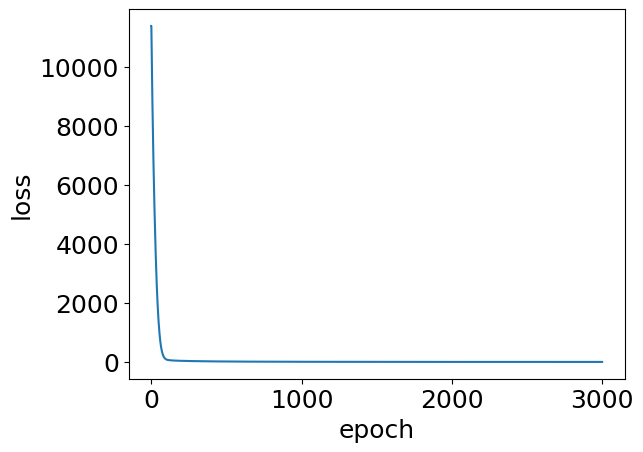

In [265]:
import matplotlib.pyplot as plt
plt.plot(ldgf.losses)
plt.xlabel('epoch')
plt.ylabel('loss')
print('loss',ldgf.losses[-1])
print('r2',ldgf.r2_score)
print('weight',ldgf.params['weight'])
print('bias',ldgf.params['bias'])

In [266]:
y_pred

array([[ 57.27134 ,  70.20066 ],
       [ 82.08204 , 100.73799 ],
       [118.81406 , 132.9762  ],
       [ 21.101822,  37.028435],
       [101.807   , 119.12064 ]], dtype=float32)

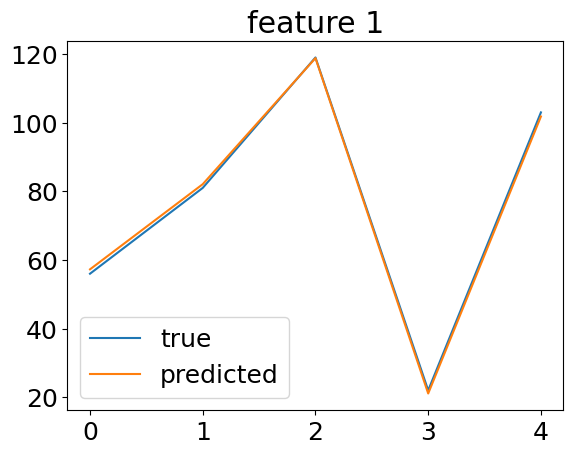

Text(0.5, 1.0, 'feature 2')

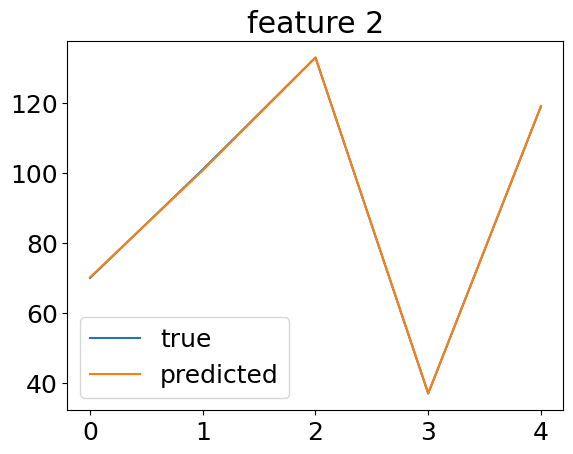

In [267]:
plt.plot(y_true[:,0],label='true')
plt.plot(y_pred[:,0],label='predicted')
plt.legend()
plt.title('feature 1')
plt.show()
plt.plot(y_true[:,1],label='true')
plt.plot(y_pred[:,1],label='predicted')
plt.legend()
plt.title('feature 2')


## Simulate data

In [268]:
np.random.seed(0)

In [269]:
T= 200 #Time
N_neurons = 10
N_features = 2
X0 = np.random.randn(T,N_neurons)
w0 = np.random.randn(N_neurons, N_features)
print(X0.shape)
print(w0.shape)
b0 = np.random.randn(N_features)
Y0 = X0 @ w0 + b0
print(Y0.shape)

(200, 10)
(10, 2)
(200, 2)


Text(0.5, 1.0, 'Simulated features')

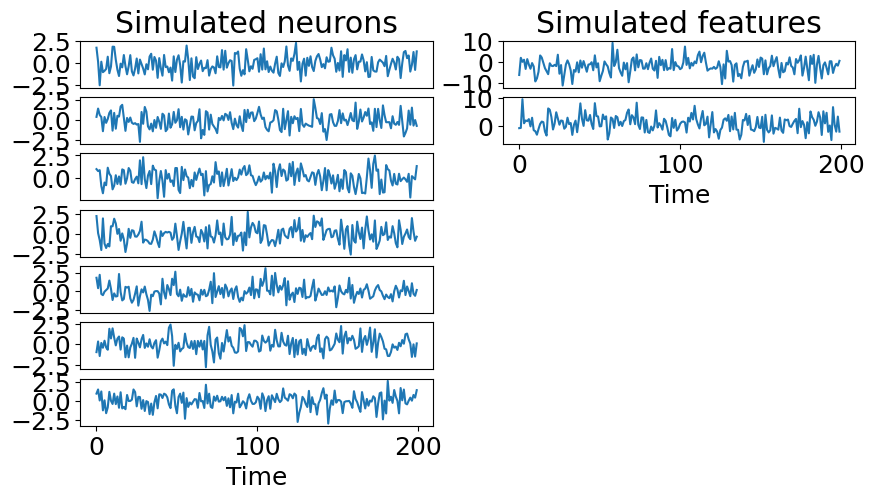

In [270]:
plt.figure(figsize=(10,5))
N_plot_neurons = 7
for i in range(N_plot_neurons):
    
    #Plot ground truth
    plt.subplot(N_plot_neurons,2,2*i+1)
    plt.plot((X0)[:,i]) 
    
    # plt.yticks([])
    if i<N_plot_neurons-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')
for i in range(N_features):
    plt.subplot(N_plot_neurons,2,2*i+2)
    plt.plot((Y0)[:,i]) 
    # plt.yticks([])    
    if i<N_features-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

plt.subplot(N_plot_neurons,2,1)
plt.title('Simulated neurons')

plt.subplot(N_plot_neurons,2,2)
plt.title('Simulated features')

In [275]:
# ldgf=LDGF(init='linear_regression')
ldgf=LDGF()

y_pred=ldgf.fit_transform(X=X0, y=Y0)
print(y_pred)
y_true = Y0
print(y_true)

100%|██████████| 3000/3000 [00:01<00:00, 2926.33it/s]

[[-6.23752975e+00 -8.36948812e-01]
 [ 2.00270844e+00 -7.53758609e-01]
 [ 7.40720034e-02  9.44424152e+00]
 [ 1.06769621e+00  8.98361623e-01]
 [-3.33258104e+00  1.89074373e+00]
 [ 1.37408698e+00  1.66412544e+00]
 [-1.25469232e+00  2.37181211e+00]
 [-3.25218058e+00 -2.10791528e-01]
 [-5.25106430e-01  2.85954857e+00]
 [-2.16165757e+00 -1.56027842e+00]
 [-9.33410072e+00 -1.92099142e+00]
 [-7.90010643e+00 -3.15745091e+00]
 [-4.69780016e+00 -1.14135838e+00]
 [ 3.12654781e+00  6.49775803e-01]
 [ 2.14204216e+00  1.49524570e+00]
 [-3.68666053e-01  1.28588629e+00]
 [-2.96803570e+00 -2.06778312e+00]
 [-4.43664312e+00 -3.46262693e+00]
 [-5.85357904e+00  6.16552496e+00]
 [-6.20966792e-01  5.67686462e+00]
 [-1.81658101e+00  3.11503148e+00]
 [-1.98865271e+00 -1.31203270e+00]
 [-1.37591743e+00  7.94016838e-01]
 [-1.96814311e+00  4.80432320e+00]
 [ 3.47809982e+00  2.59732938e+00]
 [-5.63146639e+00  3.91060174e-01]
 [-1.48073876e+00  1.88248038e+00]
 [-1.13045321e+01  1.73619580e+00]
 [-6.30686474e+00 -1

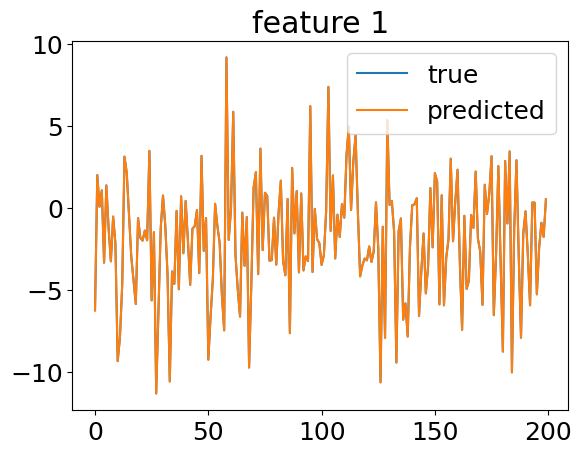

Text(0.5, 1.0, 'feature 2')

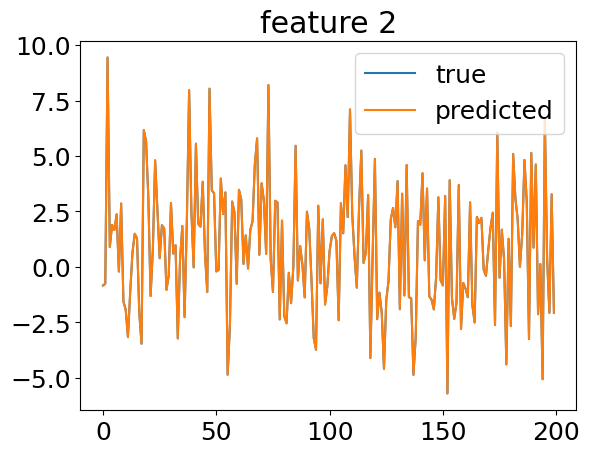

In [276]:
plt.plot(y_true[:,0],label='true')
plt.plot(y_pred[:,0],label='predicted')
plt.legend()
plt.title('feature 1')
plt.show()
plt.plot(y_true[:,1],label='true')
plt.plot(y_pred[:,1],label='predicted')
plt.legend()
plt.title('feature 2')


In [277]:
print('true weight',w0)
print('true bias',b0)

true weight [[-1.53292105 -1.71197016]
 [ 0.04613506 -0.95837448]
 [-0.08081161 -0.70385904]
 [-0.7707843  -0.48084534]
 [ 0.70358555  0.92914515]
 [ 0.37117255 -0.98982255]
 [ 0.64363128  0.68889667]
 [ 0.2746472  -0.60362044]
 [ 0.70885958  0.42281857]
 [-3.11685659  0.64445203]]
true bias [-1.91374267  0.66356158]


loss 2.646830454464122e-12
r2 0.9999999999997142
pred weight [[-1.5329206  -1.7119685 ]
 [ 0.04613511 -0.9583744 ]
 [-0.08081158 -0.70385855]
 [-0.7707842  -0.48084548]
 [ 0.70358574  0.92914534]
 [ 0.37117243 -0.9898231 ]
 [ 0.64363146  0.6888964 ]
 [ 0.27464718 -0.6036211 ]
 [ 0.70885956  0.42281866]
 [-3.1168551   0.64445215]]
pred bias [-1.913742   0.6635619]


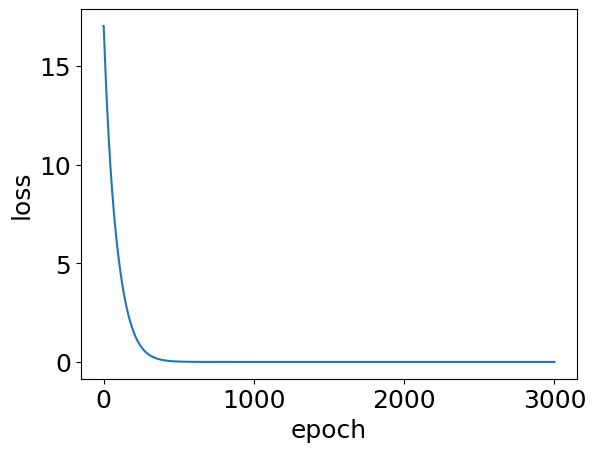

In [278]:
plt.plot(ldgf.losses)
plt.xlabel('epoch')
plt.ylabel('loss')
print('loss',ldgf.losses[-1])
print('r2',ldgf.r2_score)
print('pred weight',ldgf.params['weight'].T)
print('pred bias',ldgf.params['bias'])

## Simulate data + add filter

In [291]:
def gaussian_filter(x, sigma):
    return np.exp(-0.5*((x)/sigma)**2)

In [294]:
filter_length = 41
x_range = np.arange(-filter_length//2+1, filter_length//2+1)
sigmas = [2,5]
gaussian_filter_list = [gaussian_filter(x_range,sigmas[j]) for j in range(N_features)]

Y0_with_filter = np.stack([np.convolve(Y0[:,j], filter, mode='same') for j, filter in enumerate(gaussian_filter_list)]).T
print(Y0_with_filter.shape)

(200, 2)


In [296]:
filter = gaussian_filter(x_range, sigma=2)
X0_with_filter = np.stack([np.convolve(X0[:,j], filter,mode='same') for j in range(X0.shape[1])]).T
print(X0_with_filter.shape)

(200, 10)


Text(0.5, 1.0, 'Simulated features, filtered')

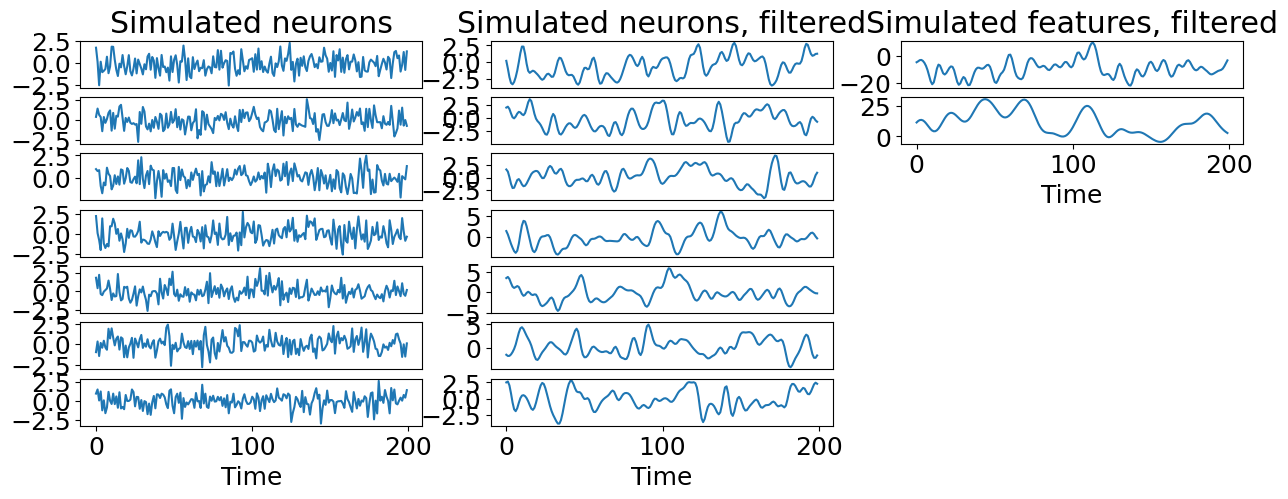

In [325]:
plt.figure(figsize=(15,5))
N_plot_neurons = 7
for i in range(N_plot_neurons):
    
    #Plot ground truth
    plt.subplot(N_plot_neurons,3,3*i+1)
    plt.plot((X0)[:,i]) 
    
    # plt.yticks([])
    if i<N_plot_neurons-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

for i in range(N_plot_neurons):
    
    #Plot ground truth
    plt.subplot(N_plot_neurons,3,3*i+2)
    plt.plot((X0_with_filter)[:,i]) 
    
    # plt.yticks([])
    if i<N_plot_neurons-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

# for i in range(N_features):
    # plt.subplot(N_plot_neurons,3,3*i+2)
    # plt.plot((Y0)[:,i]) 
    # # plt.yticks([])    
    # if i<N_features-1:
    #     plt.xticks([])
    # else:
    #     plt.xlabel('Time')

for i in range(N_features):
    plt.subplot(N_plot_neurons,3,3*i+3)
    plt.plot((Y0_with_filter)[:,i]) 
    # plt.yticks([])    
    if i<N_features-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

plt.subplot(N_plot_neurons,3,1)
plt.title('Simulated neurons')


plt.subplot(N_plot_neurons,3,2)
plt.title('Simulated neurons, filtered')

# plt.subplot(N_plot_neurons,3,2)
# plt.title('Simulated features')

plt.subplot(N_plot_neurons,3,3)
plt.title('Simulated features, filtered')

In [326]:
ldgf=LDGF(init='linear_regression')
# ldgf=LDGF()

# y_pred=ldgf.fit_transform(X=X0, y=Y0)
# y_pred=ldgf.fit_transform(X=X0, y=Y0_with_filter)
y_pred=ldgf.fit_transform(X=X0_with_filter, y=Y0_with_filter)


print(y_pred)
# y_true = Y0
y_true = Y0_with_filter
print(y_true)

100%|██████████| 3000/3000 [00:00<00:00, 3381.49it/s]

[[ -7.697937    13.122617  ]
 [ -5.294775    16.73964   ]
 [ -3.38758     19.679798  ]
 [ -2.779007    20.62219   ]
 [ -3.442573    19.664745  ]
 [ -4.968134    17.82063   ]
 [ -7.2186966   15.675606  ]
 [-10.418916    12.905257  ]
 [-14.628155     9.008255  ]
 [-18.951305     4.3427253 ]
 [-21.35247      0.36069298]
 [-19.954498    -1.3306341 ]
 [-15.019944    -0.27037334]
 [ -9.342313     2.4602413 ]
 [ -6.213463     5.251381  ]
 [ -6.8941703    7.5324707 ]
 [ -9.966271    10.159399  ]
 [-12.8338585   13.879833  ]
 [-13.742714    17.713043  ]
 [-12.655111    19.714642  ]
 [-10.622195    19.386475  ]
 [ -8.688626    18.35812   ]
 [ -7.55054     18.351519  ]
 [ -7.9135323   19.314976  ]
 [-10.44202     19.977276  ]
 [-14.89055     19.448902  ]
 [-19.488844    17.762287  ]
 [-21.802898    15.4801235 ]
 [-20.737911    13.292141  ]
 [-17.772188    11.592266  ]
 [-15.870583    10.145311  ]
 [-16.86712      8.485517  ]
 [-19.875608     6.7628646 ]
 [-22.271564     5.8902903 ]
 [-22.097197  

In [327]:
r2_score(y_true, y_pred)

0.885195607196419

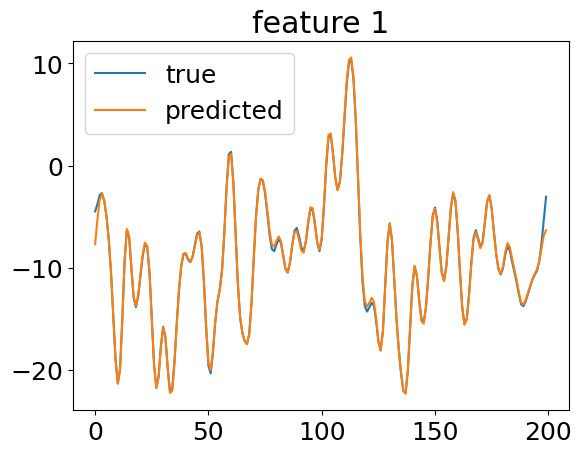

Text(0.5, 1.0, 'feature 2')

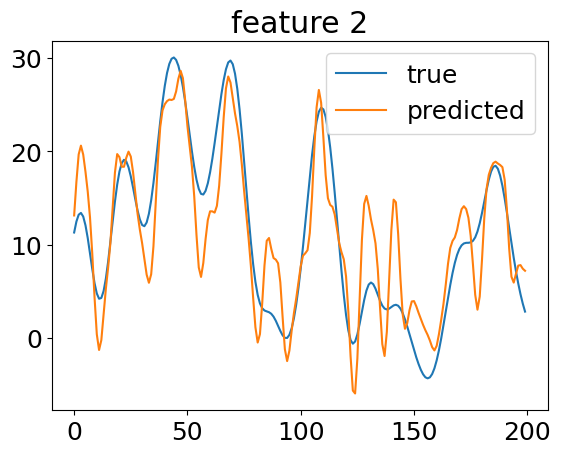

In [328]:
plt.plot(y_true[:,0],label='true')
plt.plot(y_pred[:,0],label='predicted')
plt.legend()
plt.title('feature 1')
plt.show()
plt.plot(y_true[:,1],label='true')
plt.plot(y_pred[:,1],label='predicted')
plt.legend()
plt.title('feature 2')


In [118]:
print('true weight',w0)
print('true bias',b0)

true weight [[ 1.51150747 -0.42920391]
 [-0.28149013 -0.29865051]
 [ 0.97136288  1.16593415]
 [-0.18450572  0.00658518]
 [ 0.50654829  0.19578279]
 [ 0.78521598  1.09925082]
 [-0.63815879 -0.22581109]
 [-0.05189087 -0.49103588]
 [-2.24599002 -0.79851087]
 [-0.80939372  0.24043134]]
true bias [0.43769578 0.30216343]


loss 48.62967300415039
r2 0.2332856618001672
pred weight [[-1.1433054  -1.7601234 ]
 [-0.09401717 -1.5713185 ]
 [ 0.23115276 -0.2737189 ]
 [-0.776746   -1.1029054 ]
 [ 1.3094767   1.1401082 ]
 [ 0.5429345  -0.7237291 ]
 [ 0.99719393  0.9796996 ]
 [ 0.30393025 -1.3661634 ]
 [ 1.1330309   0.2527783 ]
 [-2.5958354   1.2541279 ]]
pred bias [-9.405997 10.889363]


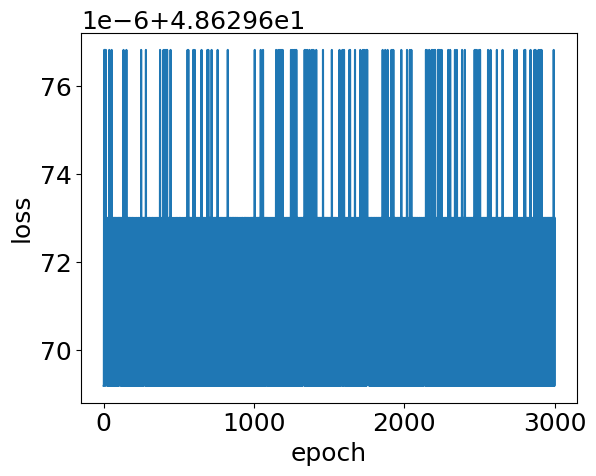

In [317]:
plt.plot(ldgf.losses)
plt.xlabel('epoch')
plt.ylabel('loss')
print('loss',ldgf.losses[-1])
print('r2',ldgf.r2_score)
print('pred weight',ldgf.params['weight'].T)
print('pred bias',ldgf.params['bias'])

# filter model

## Model

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
# Define dataset
import torch.nn.functional as F
import torch.nn.utils.parametrize as P
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression


In [225]:
class LinearModel_no_filter(nn.Module):
    ## This is just a OLS linear regression now
    ## TODO: customize cost function
    def __init__(self, input_dim, output_dim, weight_init, b_init):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = nn.Linear(input_dim, output_dim, bias = True)
        self.linear.weight = torch.nn.Parameter(torch.tensor(weight_init, dtype=torch.float))
        self.linear.bias = torch.nn.Parameter(torch.tensor(b_init, dtype=torch.float))
        
    def forward(self, x):
        output = x @ self.linear.weight.T + self.linear.bias
        return output

In [226]:
class LinearModel_with_filter(nn.Module):
    def __init__(self, input_dim, output_dim, weight_init, b_init, filter_length):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = nn.Linear(input_dim, output_dim, bias = True)
        self.linear.weight = torch.nn.Parameter(torch.tensor(weight_init, dtype=torch.float))
        self.linear.bias = torch.nn.Parameter(torch.tensor(b_init, dtype=torch.float))
        self.filter_length = filter_length
        self.sigmas = torch.nn.Parameter(torch.ones(self.output_dim))
        self._filter_range = torch.arange(-self.filter_length//2+1, self.filter_length//2+1)

    def _gaussian_filter(self, x, sigma):
        return torch.exp(-0.5*((x)/sigma)**2)
    
    def decode_filter(self, x):
        [n_trials, n_timepoints, n_neurons] = x.shape
        x_flat = x.reshape(n_trials*n_timepoints, n_neurons)
        linear_output_flat = x_flat @ self.linear.weight.T + self.linear.bias
        linear_output = linear_output_flat.reshape(n_trials, n_timepoints, self.output_dim)
        gaussian_filter_list = [self._gaussian_filter(self._filter_range,self.sigmas[j]).reshape(1,1,-1)
                                for j in range(self.output_dim)]
        filter_output = torch.stack([F.conv1d(linear_output[:,:,j].reshape(n_trials,1,-1), filter, padding='same') 
                            for j, filter in enumerate(gaussian_filter_list)]).squeeze()
        filter_output = torch.permute(filter_output,(1,2,0)).reshape(n_trials*n_timepoints,self.output_dim)
        return filter_output    

    def forward(self, x):
        output = self.decode_filter(x)
        return output
    def plottable_filters(self):
        return self._filter_range.detach().numpy(), [self._gaussian_filter(self._filter_range, self.sigmas[i]).detach().numpy() for i in range(self.output_dim)]

In [227]:
class LDGF(object):
    def __init__(self, n_epochs=3000, learning_rate = None, init = None, add_filter = True, filter_length = 41):
        self.n_epochs = n_epochs
        self.init = init
        self.learning_rate = learning_rate
        self.add_filter = add_filter
        self.filter_length = filter_length
    def fit_transform(self, X, y):
        # input shape
        # X.shape = (n_trials, n_timepoints, n_neurons)
        # y.shape = (n_trials, n_timepoints, n_features)

        if self.init is None:
            weight_init = np.random.randn(X.shape[-1], y.shape[-1]).T
            b_init = np.zeros(y.shape[-1])
        elif self.init == 'linear_regression':
            reg = LinearRegression().fit(X.reshape(-1,X.shape[-1]), y.reshape(-1, y.shape[-1]))
            weight_init = reg.coef_
            b_init = reg.intercept_

        if self.learning_rate == None:
            self.learning_rate = 0.01

        X = torch.tensor(X,dtype=torch.float)
        y = torch.tensor(y,dtype=torch.float)     

        if not self.add_filter:
            X = X.reshape(-1, X.shape[-1])
            y = y.reshape(-1, y.shape[-1])
            model = LinearModel_no_filter(X.shape[1], y.shape[1], weight_init, b_init)
            model.eval()
            y_pred = model(X)
            loss_fn = F.mse_loss
            loss = loss_fn(y_pred, y)
            losses=np.zeros(self.n_epochs+1)
            losses[0]=loss.item()
            optimizer = torch.optim.Adam(model.parameters(), lr = self.learning_rate)
            model.train()
            for epoch in tqdm(range(self.n_epochs), position=0, leave=True):
                optimizer.zero_grad()
                # Forward pass
                y_pred = model(X)
                # Compute Loss
                loss = loss_fn(y_pred, y)
                losses[epoch+1]=loss.item()
                # Backward pass
                loss.backward()
                optimizer.step()
        else:
            model = LinearModel_with_filter(X.shape[-1], y.shape[-1], weight_init, b_init, self.filter_length) 
            model.eval()
            y_pred = model(X)
            loss_fn = F.mse_loss
            y = y.reshape(-1, y.shape[-1])
            loss = loss_fn(y_pred, y)
            losses=np.zeros(self.n_epochs+1)
            losses[0]=loss.item()
            optimizer = torch.optim.Adam(model.parameters(), lr = self.learning_rate)
            model.train()
            for epoch in tqdm(range(self.n_epochs), position=0, leave=True):
                optimizer.zero_grad()
                # Forward pass
                y_pred = model(X)
                # Compute Loss
                loss = loss_fn(y_pred, y)
                losses[epoch+1]=loss.item()
                # Backward pass
                loss.backward() 
                optimizer.step()
            
        # Include attributes as part of self
        self.model=model
        self.losses=losses
        self.params={}
        self.params['weight']=model.linear.weight.detach().numpy()
        self.params['bias']=model.linear.bias.detach().numpy()
        self.r2_score=r2_score(y,y_pred.detach().numpy())
        return y_pred.detach().numpy()
    
    def fit(self, X, y):
        self.fit_transform(X,y)
        return self
    
    def transform(self, X):
        X = torch.tensor(X,dtype=torch.float)
        if not self.add_filter:
            X = X.reshape(-1, X.shape[-1])
            y_pred = self.model(X)
        else:
            y_pred = self.model(X)
        return y_pred.detach().numpy()

## Simulation

In [5]:
np.random.seed(0)

In [6]:
T= 200 #Time
N_neurons = 10
N_features = 2
X0 = np.random.randn(T,N_neurons)
w0 = np.random.randn(N_neurons, N_features)
print(X0.shape)
print(w0.shape)
b0 = np.random.randn(N_features)
Y0 = X0 @ w0 + b0
print(Y0.shape)

(200, 10)
(10, 2)
(200, 2)


In [7]:
def gaussian_filter(x, sigma):
    return np.exp(-0.5*((x)/sigma)**2)

In [38]:
filter_length = 41
x_range = np.arange(-filter_length//2+1, filter_length//2+1)
sigmas = [2,5]
gaussian_filter_list = [gaussian_filter(x_range,sigmas[j]) for j in range(N_features)]

Y0_with_filter = np.stack([np.convolve(Y0[:,j], filter, mode='same') for j, filter in enumerate(gaussian_filter_list)]).T
print(Y0_with_filter.shape)

(200, 2)


In [39]:
filter = gaussian_filter(x_range, sigma=2)
X0_with_filter = np.stack([np.convolve(X0[:,j], filter,mode='same') for j in range(X0.shape[1])]).T
print(X0_with_filter.shape)

(200, 10)


Text(0.5, 1.0, 'Simulated features, filtered')

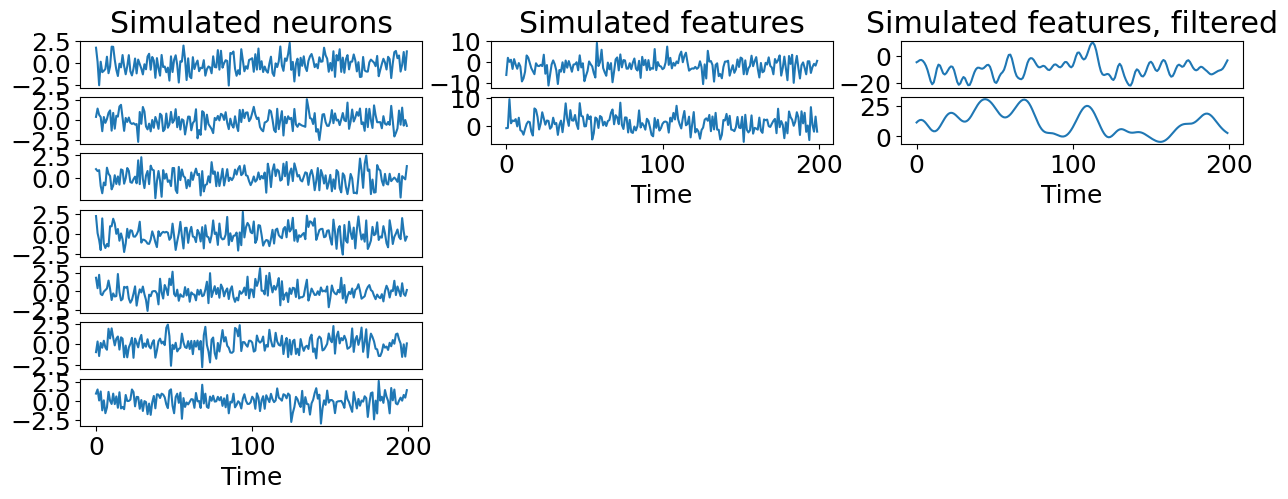

In [40]:
plt.figure(figsize=(15,5))
N_plot_neurons = 7
for i in range(N_plot_neurons):
    
    #Plot ground truth
    plt.subplot(N_plot_neurons,3,3*i+1)
    plt.plot((X0)[:,i]) 
    
    # plt.yticks([])
    if i<N_plot_neurons-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')


for i in range(N_features):
    plt.subplot(N_plot_neurons,3,3*i+2)
    plt.plot((Y0)[:,i]) 
    # plt.yticks([])    
    if i<N_features-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

for i in range(N_features):
    plt.subplot(N_plot_neurons,3,3*i+3)
    plt.plot((Y0_with_filter)[:,i]) 
    # plt.yticks([])    
    if i<N_features-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

plt.subplot(N_plot_neurons,3,1)
plt.title('Simulated neurons')


plt.subplot(N_plot_neurons,3,2)
plt.title('Simulated features')

plt.subplot(N_plot_neurons,3,3)
plt.title('Simulated features, filtered')

In [64]:
# ldgf=LDGF(init='linear_regression',n_epochs=6000)
ldgf=LDGF()
# ldgf=LDGF(add_filter = False)


# y_pred=ldgf.fit_transform(X=X0, y=Y0)
y_pred=ldgf.fit_transform(X=X0, y=Y0_with_filter)
# y_pred=ldgf.fit_transform(X=X0_with_filter, y=Y0_with_filter)

print(y_pred)
# y_true = Y0
y_true = Y0_with_filter
print(y_true)

100%|██████████| 3000/3000 [00:05<00:00, 596.67it/s]

[[-4.49057961e+00  1.12895775e+01]
 [-3.77843738e+00  1.24653683e+01]
 [-2.90149617e+00  1.32006121e+01]
 [-2.70263290e+00  1.33947334e+01]
 [-3.43205690e+00  1.30063524e+01]
 [-4.94814253e+00  1.20692139e+01]
 [-7.23334885e+00  1.06938343e+01]
 [-1.04928780e+01  9.05431938e+00]
 [-1.47215424e+01  7.36622858e+00]
 [-1.90021553e+01  5.85867167e+00]
 [-2.13372135e+01  4.74185991e+00]
 [-1.99026203e+01  4.17683840e+00]
 [-1.49837885e+01  4.25822592e+00]
 [-9.36149597e+00  5.00079441e+00]
 [-6.29496288e+00  6.34477615e+00]
 [-7.01283884e+00  8.16263294e+00]
 [-1.00899220e+01  1.02777405e+01]
 [-1.29543114e+01  1.24916706e+01]
 [-1.38769855e+01  1.46049356e+01]
 [-1.28150196e+01  1.64363976e+01]
 [-1.07930403e+01  1.78461037e+01]
 [-8.84398937e+00  1.87464581e+01]
 [-7.67961168e+00  1.91012154e+01]
 [-8.02189922e+00  1.89288349e+01]
 [-1.05289707e+01  1.83006039e+01]
 [-1.49409590e+01  1.73180962e+01]
 [-1.94911022e+01  1.61143322e+01]
 [-2.17642670e+01  1.48410244e+01]
 [-2.06777077e+01  1

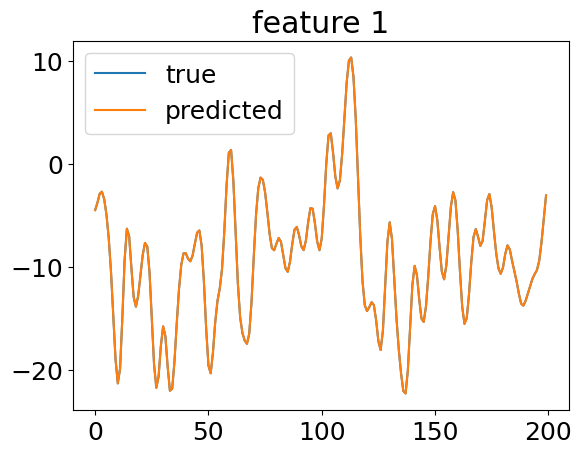

Text(0.5, 1.0, 'feature 2')

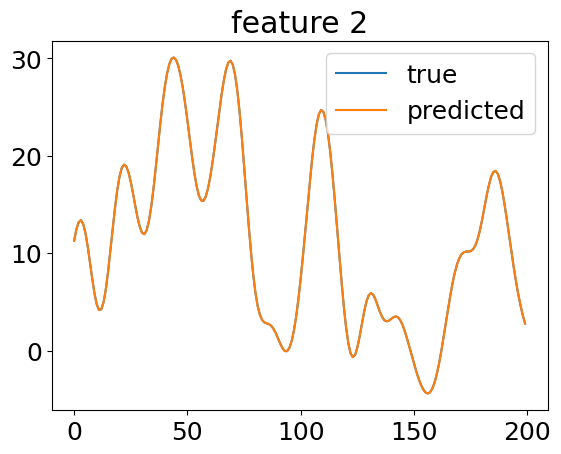

In [65]:
plt.plot(y_true[:,0],label='true')
plt.plot(y_pred[:,0],label='predicted')
plt.legend()
plt.title('feature 1')
plt.show()
plt.plot(y_true[:,1],label='true')
plt.plot(y_pred[:,1],label='predicted')
plt.legend()
plt.title('feature 2')


In [66]:
print('true weight',w0)
print('true bias',b0)

true weight [[-1.53292105 -1.71197016]
 [ 0.04613506 -0.95837448]
 [-0.08081161 -0.70385904]
 [-0.7707843  -0.48084534]
 [ 0.70358555  0.92914515]
 [ 0.37117255 -0.98982255]
 [ 0.64363128  0.68889667]
 [ 0.2746472  -0.60362044]
 [ 0.70885958  0.42281857]
 [-3.11685659  0.64445203]]
true bias [-1.91374267  0.66356158]


loss 1.629242629697103e-09
r2 0.9999999999795961
pred weight [[-1.5329204  -1.7119762 ]
 [ 0.0461354  -0.95837545]
 [-0.08081228 -0.7038583 ]
 [-0.7707831  -0.48085344]
 [ 0.70358294  0.92914426]
 [ 0.37117162 -0.9898206 ]
 [ 0.6436312   0.68890166]
 [ 0.27464685 -0.60362965]
 [ 0.7088585   0.42280635]
 [-3.1168532   0.6444485 ]]
pred bias [-1.9137379   0.66356915]


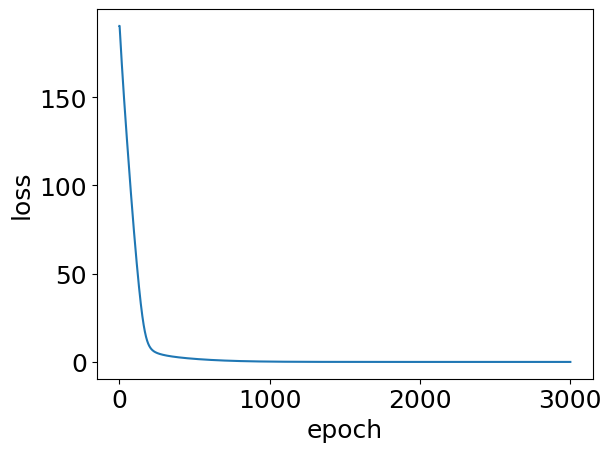

In [67]:
plt.plot(ldgf.losses)
plt.xlabel('epoch')
plt.ylabel('loss')
print('loss',ldgf.losses[-1])
print('r2',ldgf.r2_score)
print('pred weight',ldgf.params['weight'].T)
print('pred bias',ldgf.params['bias'])

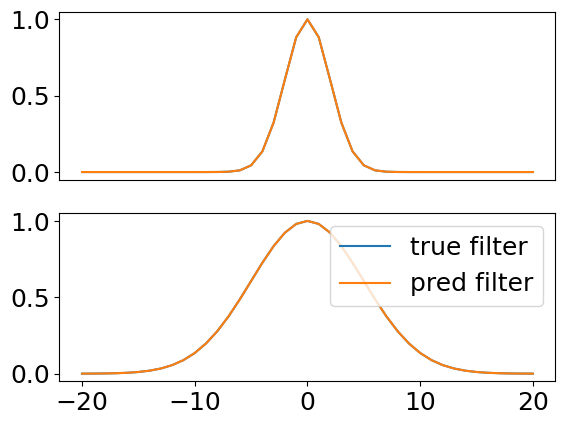

In [69]:
x, y = ldgf.model.plottable_filters()
j=0
for i in range(N_features):
    plt.subplot(N_features, 1,i+1)
    plt.plot(x,gaussian_filter_list[i],label='true filter')
    plt.plot(x,y[i],label='pred filter')
    if i < N_features-1:
        plt.xticks([])
    j+=2
plt.legend()

## Real data

In [6]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import math
import multiprocessing as mp
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history
from Area2_analysis.lr_funcs import angle_between, process_train_test, gaussian_filter1d_oneside, comp_cc,xcorr
from Area2_analysis.lr_funcs import get_sses_pred, get_sses_mean, nans, fit_and_predict, sub_and_predict, pred_with_new_weights
matplotlib.rc('font', size=18)

### Import

In [7]:
foldername = "~/area2_population_analysis/s1-kinematics/actpas_NWB/"
monkey = "Han_20171207"
filename = foldername + monkey + "_COactpas_TD.nwb"
dataset_10ms = NWBDataset(filename, split_heldout=False)
dataset_10ms.resample(10) #in 10-ms bin, has to resample first to avoid NaNs
bin_width = dataset_10ms.bin_width
print(bin_width)
xy_vel = dataset_10ms.data['hand_vel'].to_numpy()
xy_acc = np.diff(xy_vel, axis = 0, prepend=[xy_vel[0]])
dataset_10ms.add_continuous_data(xy_acc,'hand_acc',chan_names = ['x','y'])
dataset_10ms.smooth_spk(40, name='smth_40')

10


In [8]:
n_dims = 20 # for PCA

n_trials = dataset_10ms.trial_info.shape[0]
print(n_trials,'total trials')
n_neurons = dataset_10ms.data.spikes.shape[1]
print(n_neurons,'neurons')

all_data = np.array(dataset_10ms.data.spikes)
print(all_data.shape)
if not np.isnan(all_data).any():
    scaler = StandardScaler()
    X = scaler.fit_transform(all_data)
    pca = PCA(n_components=n_dims,random_state = 42)
    PCA_data = pca.fit_transform(X)
print(PCA_data.shape)
dataset_10ms.add_continuous_data(PCA_data,'PCA')
print('PCA total var explained:',sum(pca.explained_variance_ratio_))

n_trials = dataset_10ms.trial_info.shape[0]
print(n_trials,'total trials')
n_neurons = dataset_10ms.data.spikes.shape[1]
print(n_neurons,'neurons')

all_data = np.array(dataset_10ms.data.spikes_smth_40)
print(all_data.shape)
if not np.isnan(all_data).any():
    scaler = StandardScaler()
    X = scaler.fit_transform(all_data)
    pca = PCA(n_components=n_dims,random_state = 42)
    PCA_data = pca.fit_transform(X)
print(PCA_data.shape)
dataset_10ms.add_continuous_data(PCA_data,'PCA_40')
print('PCA total var explained:',sum(pca.explained_variance_ratio_))


1034 total trials
153 neurons
(279131, 153)
(279131, 20)
PCA total var explained: 0.20439086020638275
1034 total trials
153 neurons
(279131, 153)
(279131, 20)
PCA total var explained: 0.3875239497082562


In [9]:
#make dictionary for trial condition (reaching directions) for Stratified CV
dataset = dataset_10ms
active_mask = (dataset.trial_info.ctr_hold_bump==0) & (dataset.trial_info['split'] != 'none')
passive_mask = (dataset.trial_info.ctr_hold_bump==1) & (dataset.trial_info['split'] != 'none')
nan_mask = (np.isnan(dataset.trial_info.ctr_hold_bump)) & (dataset.trial_info['split'] != 'none')
all_mask = (dataset.trial_info['split'] != 'none')

trial_mask = all_mask
valid_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(valid_n_trials,'valid trials')


trial_mask = active_mask
active_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
active_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(active_n_trials,'active trials')

trial_mask = passive_mask
passive_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
passive_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(passive_n_trials,'passive trials')

trial_mask = nan_mask
nan_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(nan_n_trials,'reach bump trials')

active_cond_dir_idx = []
passive_cond_dir_idx = []
for direction in [0,45,90,135,180,225,270,315]:
    active_cond_dir_idx.append(np.where((dataset.trial_info['cond_dir'] == direction) & (dataset.trial_info['ctr_hold_bump'] == 0) & \
           (dataset.trial_info['split'] != 'none'))[0])
    passive_cond_dir_idx.append(np.where((dataset.trial_info['cond_dir']%360 == direction) & (dataset.trial_info['ctr_hold_bump'] == 1) & \
           (dataset.trial_info['split'] != 'none'))[0])

active_cond_dict = nans([active_n_trials])
i = 0
for idx in active_trials_idx:
    for cond in range(0,len(active_cond_dir_idx)):
        if idx in active_cond_dir_idx[cond]:
            active_cond_dict[i] = cond
            break
    i+=1
print(active_cond_dict)
print(len(active_cond_dict))

passive_cond_dict = nans([passive_n_trials])
i = 0
for idx in passive_trials_idx:
    for cond in range(0,len(passive_cond_dir_idx)):
        if idx in passive_cond_dir_idx[cond]:
            passive_cond_dict[i] = cond
            break
    i+=1
print(passive_cond_dict)
print(len(passive_cond_dict))

463 valid trials
245 active trials
218 passive trials
0 reach bump trials
[6. 4. 5. 4. 0. 2. 0. 5. 4. 1. 6. 5. 6. 3. 7. 5. 2. 0. 0. 5. 0. 6. 4. 2.
 2. 7. 0. 4. 4. 7. 5. 2. 6. 3. 2. 5. 5. 1. 1. 5. 5. 1. 6. 3. 7. 0. 4. 2.
 1. 5. 1. 1. 1. 1. 1. 6. 2. 0. 5. 4. 7. 6. 3. 1. 5. 3. 0. 4. 6. 6. 0. 1.
 3. 0. 6. 3. 1. 4. 3. 4. 5. 2. 2. 3. 3. 3. 4. 4. 2. 1. 2. 2. 4. 6. 1. 5.
 0. 2. 0. 4. 6. 5. 6. 3. 0. 0. 6. 7. 2. 0. 0. 5. 7. 5. 1. 4. 2. 0. 0. 5.
 4. 6. 3. 6. 3. 6. 3. 1. 7. 3. 3. 7. 5. 5. 3. 1. 5. 0. 7. 4. 7. 5. 5. 1.
 6. 3. 3. 2. 1. 7. 5. 5. 0. 1. 6. 2. 7. 1. 0. 0. 3. 4. 1. 2. 0. 3. 0. 2.
 5. 1. 3. 0. 7. 2. 3. 1. 2. 2. 0. 4. 2. 1. 3. 5. 5. 2. 1. 4. 1. 1. 6. 4.
 1. 4. 7. 0. 2. 5. 6. 2. 1. 1. 5. 7. 1. 1. 2. 2. 5. 0. 6. 0. 0. 0. 3. 7.
 7. 0. 7. 0. 3. 0. 7. 7. 5. 3. 0. 7. 3. 0. 6. 4. 3. 0. 0. 4. 3. 3. 6. 1.
 0. 2. 0. 0. 3.]
245
[6. 3. 3. 2. 4. 0. 6. 1. 0. 3. 2. 7. 6. 6. 6. 5. 4. 5. 3. 0. 4. 1. 6. 6.
 1. 5. 1. 0. 7. 1. 4. 4. 7. 6. 7. 3. 3. 0. 3. 5. 6. 6. 3. 2. 1. 1. 4. 7.
 5. 4. 4. 4. 7. 4. 3. 0. 7. 0

In [10]:
dataset = dataset_10ms
x_field = 'PCA_40'
y_field ='hand_vel'
lag_axis = np.arange(-300,300,20)
trial_mask = active_mask
cond_dict = active_cond_dict
# trial_mask = passive_mask
# cond_dict = passive_cond_dict

figDir = '/Users/sherryan/area2_population_analysis/figures_plus/PCA/'
dim = n_dims

In [58]:
# import scipy.stats
# pred_range = (-100, 1000)
# r2_array = nans([len(lag_axis)]); x_r2_array = nans([len(lag_axis)]); y_r2_array = nans([len(lag_axis)])
# r_array = nans([len(lag_axis)])
# coef_array = nans([len(lag_axis),2,dim])
# for i in range(len(lag_axis)):
#     lag = lag_axis[i]
#     r2, coef,_,vel_df,x_r2, y_r2 = fit_and_predict(dataset, trial_mask, 'move_onset_time',pred_range, lag, x_field, y_field,cond_dict)
#     r2_array[i] = r2; x_r2_array[i] = x_r2; y_r2_array[i] = y_r2
#     r = scipy.stats.pearsonr(vel_df[y_field].to_numpy().reshape(-1), vel_df['pred_vel'].to_numpy().reshape(-1))[0]
#     r_array[i] = r
#     coef_array[i,:,:] = coef
# time_max = lag_axis[np.argmax(r2_array)]
# print(np.max(r2_array))
# _, best_coef,best_intercept, vel_df, x_r2, y_r2 = fit_and_predict(dataset, trial_mask, 'move_onset_time',pred_range, time_max, x_field, y_field, cond_dict = cond_dict)

In [57]:
# # Prepare for plotting
# plot_dir = [0.0, 90.0, 180.0, 270.0] # limit plot directions to reduce cluttering
# colors = ['red', 'blue', 'green', 'orange']
# plot_dim = 'x' # plot x velocity 

# x_axis = np.arange(-100,1000,dataset.bin_width)
# fig, ax = plt.subplots()
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# for trial_dir, color in zip(plot_dir, colors):
#     cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
#     for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
#         plt.plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
#         # plt.plot(x_axis, trial[y_field].to_numpy()[:,0], color=color, linewidth=0.5)
# plt.xlabel('Time after movement onset (ms)')
# # plt.ylabel('Shoulder angle')
# # plt.ylabel('Shoulder velocity')
# # plt.ylabel('Muscle pc (au)')
# # plt.ylabel('Hand position (cm)')
# # plt.ylabel('Hand velocity (cm/s)')
# plt.ylabel('Hand velocity (cm/s)')

# # plt.xlim([-100,500])
# # plt.ylim([-0.65,0.65])
# plt.tight_layout()
# # plt.savefig(figDir + monkey + label + 'true.pdf', dpi = 'figure')
# plt.show()

# fig, ax = plt.subplots()
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# for trial_dir, color in zip(plot_dir, colors):
#     cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
#     for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
#          plt.plot(x_axis, trial['pred_vel'][plot_dim], color=color, linewidth=0.5)
#         # plt.plot(x_axis, trial.pred_vel.to_numpy()[:,0], color=color, linewidth=0.5)
# plt.xlabel('Time after movement onset (ms)')
# # plt.ylabel('Shoulder angle')
# # plt.ylabel('Shoulder velocity')
# # plt.ylabel('Muscle pc (au)')
# # plt.ylabel('Hand position (cm)')
# # plt.ylabel('Hand velocity (cm/s)')
# plt.ylabel('Hand velocity  (cm/s)')
# # plt.xlim([-100,500])
# # plt.ylim([-0.65,0.65])
# plt.tight_layout()
# # plt.savefig(figDir + monkey + label + str(0) +'_pred.pdf', dpi = 'figure')
# plt.show()

# plot_dim = 'y' # plot x velocity 

# x_axis = np.arange(-100,1000,dataset.bin_width)
# fig, ax = plt.subplots()
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# for trial_dir, color in zip(plot_dir, colors):
#     cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
#     for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
#         plt.plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
#         # plt.plot(x_axis, trial[y_field].to_numpy()[:,0], color=color, linewidth=0.5)
# plt.xlabel('Time after movement onset (ms)')
# # plt.ylabel('Shoulder angle')
# # plt.ylabel('Shoulder velocity')
# # plt.ylabel('Muscle pc (au)')
# # plt.ylabel('Hand position (cm)')
# # plt.ylabel('Hand velocity (cm/s)')
# plt.ylabel('Hand velocity (cm/s)')

# # plt.xlim([-100,500])
# # plt.ylim([-0.65,0.65])
# plt.tight_layout()
# # plt.savefig(figDir + monkey + label + 'true.pdf', dpi = 'figure')
# plt.show()

# fig, ax = plt.subplots()
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# for trial_dir, color in zip(plot_dir, colors):
#     cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
#     for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
#          plt.plot(x_axis, trial['pred_vel'][plot_dim], color=color, linewidth=0.5)
#         # plt.plot(x_axis, trial.pred_vel.to_numpy()[:,0], color=color, linewidth=0.5)
# plt.xlabel('Time after movement onset (ms)')
# # plt.ylabel('Shoulder angle')
# # plt.ylabel('Shoulder velocity')
# # plt.ylabel('Muscle pc (au)')
# # plt.ylabel('Hand position (cm)')
# # plt.ylabel('Hand velocity (cm/s)')
# plt.ylabel('Hand velocity  (cm/s)')
# # plt.xlim([-100,500])
# # plt.ylim([-0.65,0.65])
# plt.tight_layout()
# # plt.savefig(figDir + monkey + label + str(0) +'_pred.pdf', dpi = 'figure')
# plt.show()

# fig, ax = plt.subplots()
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.plot(lag_axis, x_r2_array,color = 'k')
# plt.axvline(time_max, color = 'k', linestyle='--')
# print(r2_array)
# print(time_max)
# # plt.title('R2 score predicting ' + y_field + ' ' + str(pred_range))
# plt.xlabel('Time lag (ms)')
# plt.ylabel('X R2')
# # plt.ylim([0.00,0.5])
# plt.tight_layout()
# # plt.savefig(figDir + monkey +'_acc_' + str(0) +'.pdf', dpi = 'figure')
# plt.show()

# fig, ax = plt.subplots()
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.plot(lag_axis, y_r2_array,color = 'k')
# plt.axvline(time_max, color = 'k', linestyle='--')
# print(r2_array)
# print(time_max)
# # plt.title('R2 score predicting ' + y_field + ' ' + str(pred_range))
# plt.xlabel('Time lag (ms)')
# plt.ylabel('Y R2')
# # plt.ylim([0.00,0.5])
# plt.tight_layout()
# # plt.savefig(figDir + monkey +'_acc_' + str(0) +'.pdf', dpi = 'figure')
# plt.show()


# fig, ax = plt.subplots()
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.plot(lag_axis, r2_array,color = 'k')
# plt.axvline(time_max, color = 'k', linestyle='--')
# print(r2_array)
# print(time_max)
# # plt.title('R2 score predicting ' + y_field + ' ' + str(pred_range))
# plt.xlabel('Time lag (ms)')
# plt.ylabel('R2')
# # plt.ylim([0.00,0.5])
# plt.tight_layout()
# # plt.savefig(figDir + monkey +'_acc_' + str(0) +'.pdf', dpi = 'figure')
# plt.show()


# fig, ax = plt.subplots()
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.plot(lag_axis, r_array,color = 'k')
# plt.axvline(time_max, color = 'k', linestyle='--')
# print(time_max)
# plt.xlabel('Time lag (ms)')
# plt.ylabel('r')
# # plt.ylim([0.05,0.8])
# plt.tight_layout()
# # plt.savefig(figDir + monkey +'_vel_' + str(0) +'.pdf', dpi = 'figure')
# plt.show()

# idx_max_pos = np.argwhere(r2_array == np.max(r2_array[np.argwhere(lag_axis==0)[0,0]:]))[0,0]
# idx_max_neg = np.argwhere(r2_array == np.max(r2_array[:np.argwhere(lag_axis==0)[0,0]]))[0,0]
# print(lag_axis[idx_max_pos])
# print(lag_axis[idx_max_neg])

# #For velocity, override max identification
# # idx_max_pos = np.argwhere(lag_axis==80)[0,0]
# # idx_max_neg = np.argwhere(lag_axis==-40)[0,0]

# ang_to_max_x = nans([len(lag_axis)])
# ang_to_max_y = nans([len(lag_axis)])
# # ang_to_max_z = nans([len(lag_axis)])
# for i in range(0, len(coef_array)):
#     ang_to_max_x[i] = math.degrees(angle_between(coef_array[i,0,:],coef_array[idx_max_pos,0,:]))
#     ang_to_max_y[i] = math.degrees(angle_between(coef_array[i,1,:],coef_array[idx_max_pos,1,:]))
#     # ang_to_max_z[i] = math.degrees(angle_between(coef_array[i,2,:],coef_array[idx_max_neg,2,:]))
# fig, ax = plt.subplots()
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# # plt.ylim([-5, 130])
# plt.xlim([-310, 310])
# plt.scatter(lag_axis, ang_to_max_x,label = 'x',color = 'green')
# plt.scatter(lag_axis, ang_to_max_y,label = 'y',color = 'blue')
# # plt.scatter(lag_axis, ang_to_max_z,label = 'wrist_abduction',color = 'orange')

# plt.legend()
# plt.xlabel('Time lag (ms)')
# plt.ylabel('Angle (degrees)')
# mean = np.mean([ang_to_max_x[idx_max_pos], ang_to_max_y[idx_max_pos]])
# print(mean)
# # plt.vlines(lag_axis[idx_max_pos],-5, mean, color = 'k',linestyle="dashed")
# # plt.hlines(mean, -310, lag_axis[idx_max_pos], color = 'k',linestyle="dashed")
# plt.tight_layout()
# # plt.savefig(figDir + monkey + label + str(0) +'_angle.pdf', dpi = 'figure')
# plt.show()



### Try model

In [228]:
# same as process_train_test, keep 3d dim for filter 
def process_train_test_keep_dim(X,y,training_set,test_set):
    """ Returns flattened X_train, X_test, y_train, y_test, tailored for the data in trial structure """
    X_train = X[training_set,:,:]
    X_test = X[test_set,:,:]
    y_train = y[training_set,:,:]
    y_test = y[test_set,:,:]

    #flat by trials
    X_flat_train = X_train.reshape((X_train.shape[0]*X_train.shape[1]),X_train.shape[2])
    X_flat_test = X_test.reshape((X_test.shape[0]*X_test.shape[1]),X_test.shape[2])
    y_flat_train = y_train.reshape((y_train.shape[0]*y_train.shape[1]),y_train.shape[2])
    y_flat_test = y_test.reshape((y_test.shape[0]*y_test.shape[1]),y_test.shape[2])
    
    X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
    X_flat_train_std=np.nanstd(X_flat_train,axis=0)   

    X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
    X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std

    y_flat_train_mean = np.mean(y_flat_train,axis=0)
    y_flat_train = y_flat_train - y_flat_train_mean
    y_flat_test = y_flat_test - y_flat_train_mean    
    
    return X_flat_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2]), X_flat_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2]), \
        y_flat_train.reshape(y_train.shape[0],y_train.shape[1],y_train.shape[2]), y_flat_test.reshape(y_test.shape[0],y_test.shape[1],y_test.shape[2])


In [235]:
##TODO: add loss function
import pandas as pd
def fit_and_predict_LDGF(dataset, trial_mask, align_field, align_range, lag, x_field, y_field,cond_dict=None, filter=True,init=None):
    """ Fits ridge regression and returns R2, regression weights, and predictions """
    # Extract kinematics data from selected trials
    vel_df = dataset.make_trial_data(align_field=align_field, align_range=align_range, ignored_trials=~trial_mask)
    # Lag alignment for rates and extract rates data from selected trials
    lag_align_range = (align_range[0] + lag, align_range[1] + lag)
    rates_df = dataset.make_trial_data(align_field=align_field, align_range=lag_align_range, ignored_trials=~trial_mask)
    
    n_trials = rates_df['trial_id'].nunique()
    n_timepoints = int((align_range[1] - align_range[0])/dataset.bin_width)
    n_neurons = rates_df[x_field].shape[1]

    ## TODO: add filter function to a 3D data
    ldgf_all = LDGF(add_filter=filter,init=init)
    rates_array = rates_df[x_field].to_numpy()
    X = (rates_array - np.nanmean(rates_array,axis=0))/np.nanstd(rates_array,axis=0)
    vel_array = vel_df[y_field].to_numpy()
    Y = vel_array - np.nanmean(vel_array,axis=0)
    Y_hat = ldgf_all.fit_transform(X.reshape(n_trials, n_timepoints, n_neurons),Y.reshape(n_trials, n_timepoints, -1))
    pred_vel = Y_hat + np.nanmean(vel_array,axis=0)
    
    n_features = vel_array.shape[-1]
    if n_features == 2:
        vel_df = pd.concat([vel_df, pd.DataFrame(pred_vel, columns=dataset._make_midx('pred_vel', ['x', 'y'], 2))], axis=1)
    elif n_features == 3:
        vel_df = pd.concat([vel_df, pd.DataFrame(pred_vel, columns=dataset._make_midx('pred_vel', ['x', 'y','z'], 3))], axis=1)
    else:
        vel_df = pd.concat([vel_df, pd.DataFrame(pred_vel, columns=dataset._make_midx('pred_vel', num_channels=n_features))], axis=1)
    plt.plot(ldgf_all.losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
    if filter:
        x_time, y_weight = ldgf_all.model.plottable_filters()
        j=0
        for i in range(n_features):
            plt.subplot(n_features, 1,i+1)
            plt.plot(x_time,y_weight[i])
            if i < n_features-1:
                plt.xticks([])
            j+=2
        # plt.legend()
        plt.show()
    print('loss',ldgf_all.losses[-1])
    print('r2',ldgf_all.r2_score)

    rates_array = rates_array.reshape(n_trials, n_timepoints, n_neurons)
    vel_array = vel_array.reshape(n_trials, n_timepoints, -1)
    if not (cond_dict is None):
        if not filter:
            skf = StratifiedKFold(n_splits=5,shuffle=True,random_state = 42)   
            true_concat = nans([n_trials*n_timepoints,n_features])
            pred_concat = nans([n_trials*n_timepoints,n_features])
            trial_save_idx = 0
            for training_set, test_set in skf.split(range(0,n_trials),cond_dict):
                #split training and testing by trials
                X_train, X_test, y_train, y_test = process_train_test_keep_dim(rates_array,vel_array,training_set,test_set)
                # ldgf = LDGF(add_filter=filter,init='linear_regression')
                ldgf = LDGF(add_filter=filter,init=init)
                ldgf.fit(X_train, y_train)
                y_test_predicted = ldgf.transform(X_test)
                n = y_test_predicted.shape[0]
                true_concat[trial_save_idx:trial_save_idx+n,:] = y_test.reshape(n,-1)
                pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
                trial_save_idx += n
            
            sses =get_sses_pred(true_concat[:,0],pred_concat[:,0])
            sses_mean=get_sses_mean(true_concat[:,0])
            x_R2 =1-np.sum(sses)/np.sum(sses_mean)    
            
            sses =get_sses_pred(true_concat[:,1],pred_concat[:,1])
            sses_mean=get_sses_mean(true_concat[:,1])
            y_R2 =1-np.sum(sses)/np.sum(sses_mean)  
            
            sses =get_sses_pred(true_concat,pred_concat)
            sses_mean=get_sses_mean(true_concat)
            R2 =1-np.sum(sses)/np.sum(sses_mean)     
            return R2, ldgf_all, vel_df, x_R2, y_R2
        else:
            skf = StratifiedKFold(n_splits=5,shuffle=True,random_state = 42)   
            true_concat = nans([n_trials*n_timepoints,n_features])
            pred_concat_wo_filter = nans([n_trials*n_timepoints,n_features])
            pred_concat_with_filter = nans([n_trials*n_timepoints,n_features])
            trial_save_idx = 0
            for training_set, test_set in skf.split(range(0,n_trials),cond_dict):
                #split training and testing by trials
                X_train, X_test, y_train, y_test = process_train_test_keep_dim(rates_array,vel_array,training_set,test_set)
                # ldgf = LDGF(add_filter=filter,init='linear_regression')
                ldgf = LDGF(add_filter=filter,init=init)
                ldgf.fit(X_train, y_train)
                y_test_predicted = ldgf.transform(X_test)
                X_test_flat = X_test.reshape(-1,n_neurons)
                y_test_predicted_wo_filter = X_test_flat @ ldgf.model.linear.weight.detach().numpy().T + ldgf.model.linear.bias.detach().numpy()
                n = y_test_predicted.shape[0]
                true_concat[trial_save_idx:trial_save_idx+n,:] = y_test.reshape(n,n_features)
                pred_concat_with_filter[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
                pred_concat_wo_filter[trial_save_idx:trial_save_idx+n,:] = y_test_predicted_wo_filter
                trial_save_idx += n
            
            sses =get_sses_pred(true_concat[:,0],pred_concat_with_filter[:,0])
            sses_mean=get_sses_mean(true_concat[:,0])
            x_R2 =1-np.sum(sses)/np.sum(sses_mean)    
            
            sses =get_sses_pred(true_concat[:,1],pred_concat_with_filter[:,1])
            sses_mean=get_sses_mean(true_concat[:,1])
            y_R2 =1-np.sum(sses)/np.sum(sses_mean)  
            
            sses =get_sses_pred(true_concat,pred_concat_with_filter)
            sses_mean=get_sses_mean(true_concat)
            R2 =1-np.sum(sses)/np.sum(sses_mean)     
            
            sses =get_sses_pred(true_concat,pred_concat_wo_filter)
            sses_mean=get_sses_mean(true_concat)
            R2_wo =1-np.sum(sses)/np.sum(sses_mean)   
            return R2, R2_wo, ldgf_all, vel_df, x_R2, y_R2

In [254]:
dataset = dataset_10ms
x_field = 'spikes'
y_field ='hand_vel'
n_features = 2
lag_axis = np.arange(-300,300,20)
trial_mask = active_mask
cond_dict = active_cond_dict
# trial_mask = passive_mask
# cond_dict = passive_cond_dict

figDir = '/Users/sherryan/area2_population_analysis/figures_plus/PCA/'
dim = n_neurons

100%|██████████| 3000/3000 [00:47<00:00, 62.99it/s]


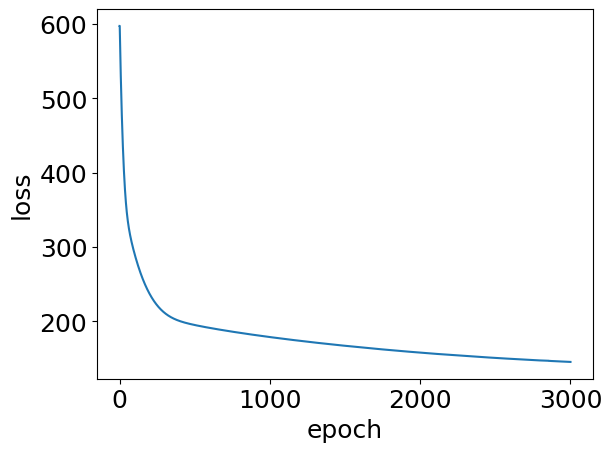

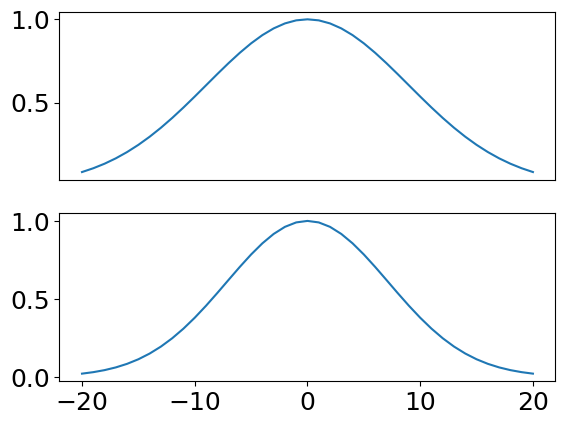

loss 145.5301513671875
r2 0.45126566653737854


100%|██████████| 3000/3000 [00:43<00:00, 69.18it/s]


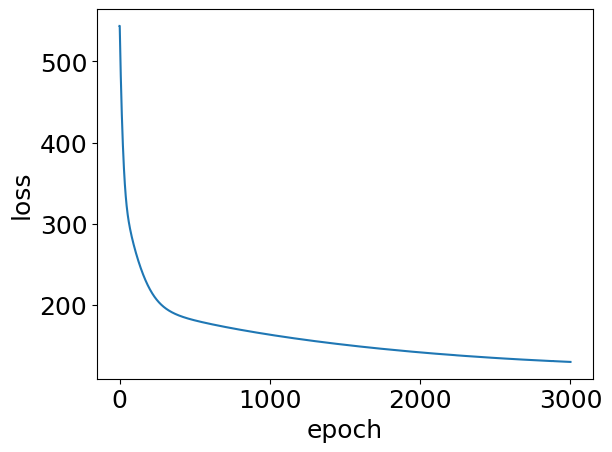

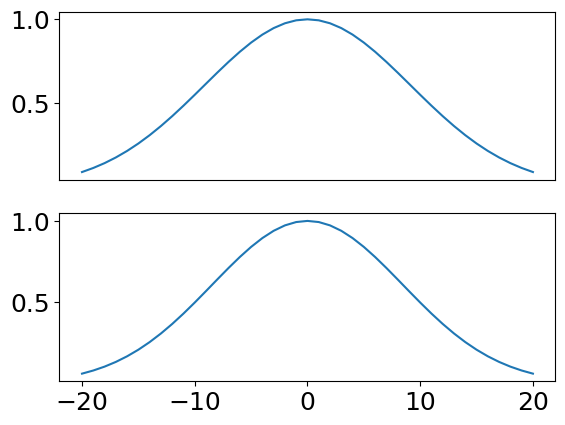

loss 129.94200134277344
r2 0.5068496391814268


100%|██████████| 3000/3000 [00:43<00:00, 69.60it/s]


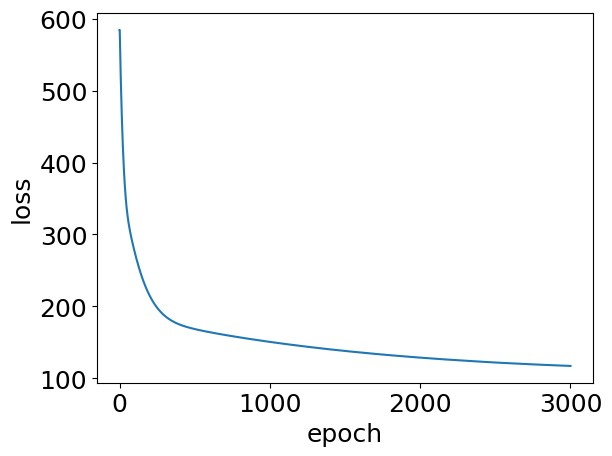

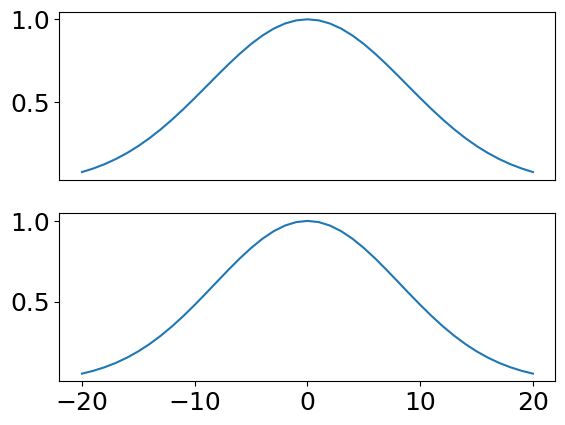

loss 117.3676528930664
r2 0.5512146842139669


100%|██████████| 3000/3000 [00:43<00:00, 68.69it/s]


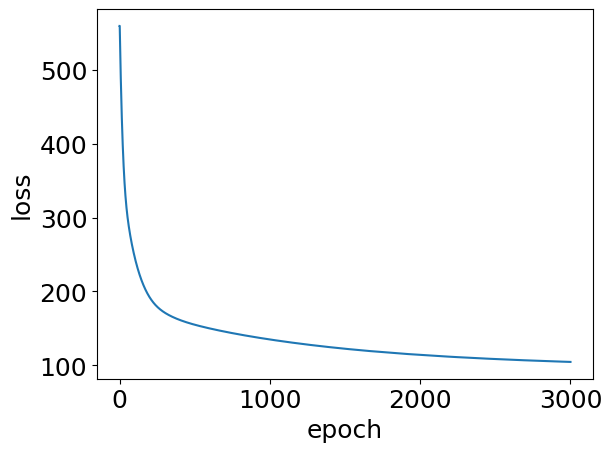

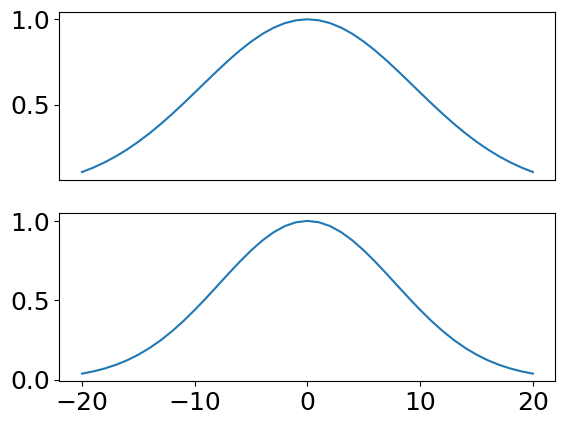

loss 104.64614868164062
r2 0.596009751308658


100%|██████████| 3000/3000 [00:42<00:00, 69.77it/s]


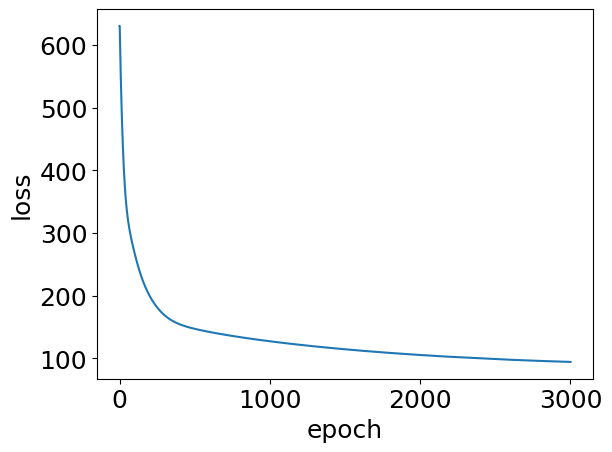

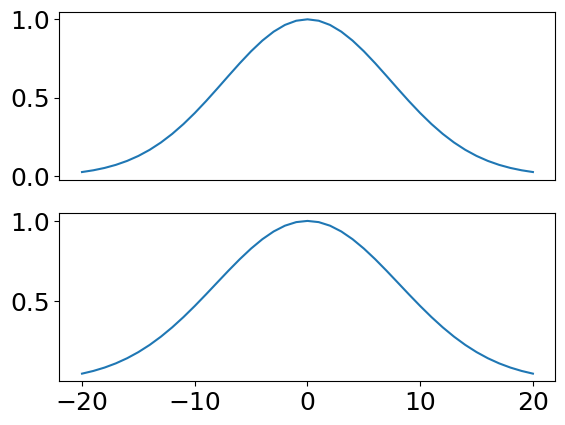

loss 94.19267272949219
r2 0.6359452320903782


100%|██████████| 3000/3000 [00:42<00:00, 70.18it/s]


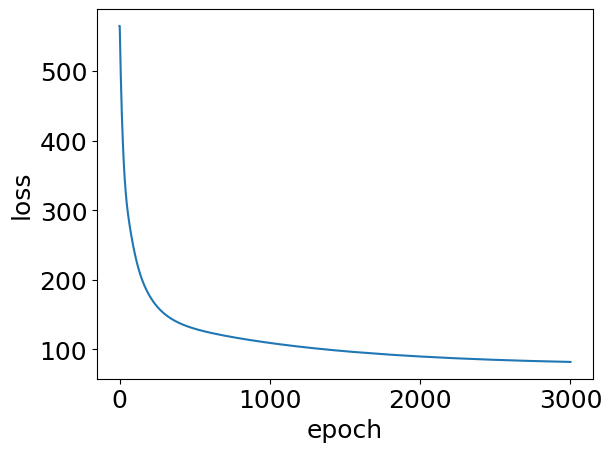

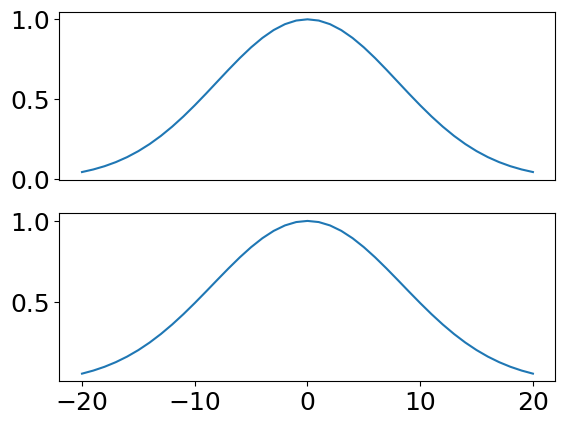

loss 82.00865173339844
r2 0.6813381376802596


100%|██████████| 3000/3000 [00:43<00:00, 69.19it/s]


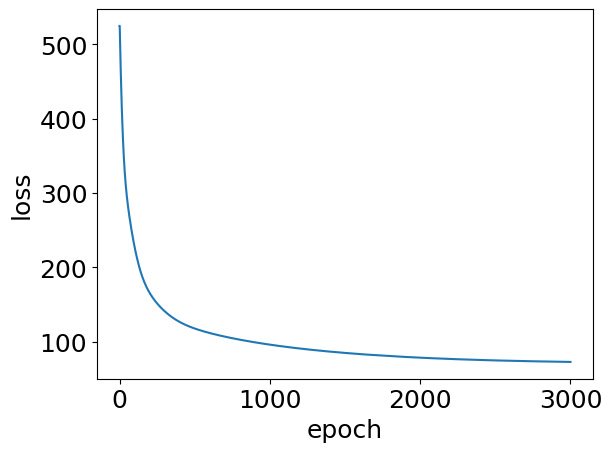

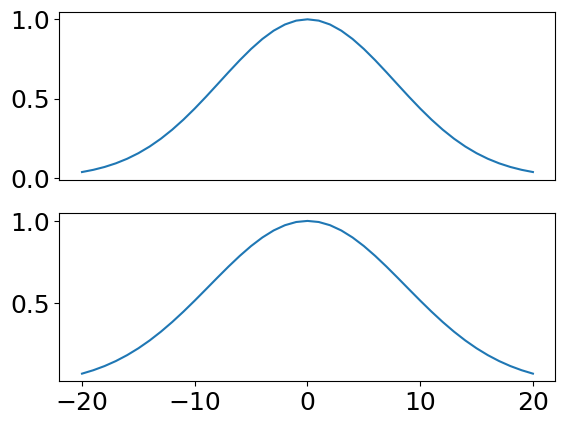

loss 72.76762390136719
r2 0.7172099482264798


100%|██████████| 3000/3000 [00:41<00:00, 72.71it/s]


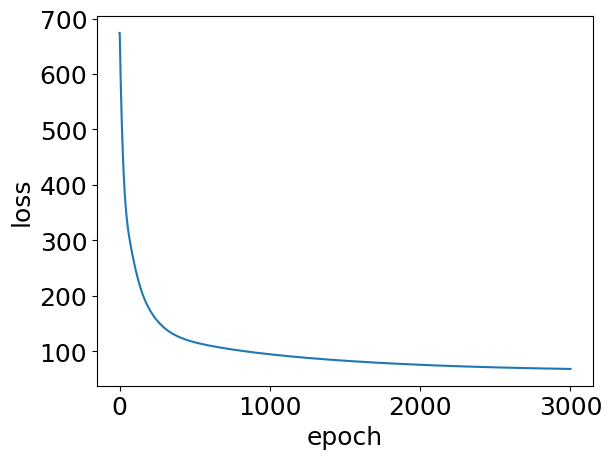

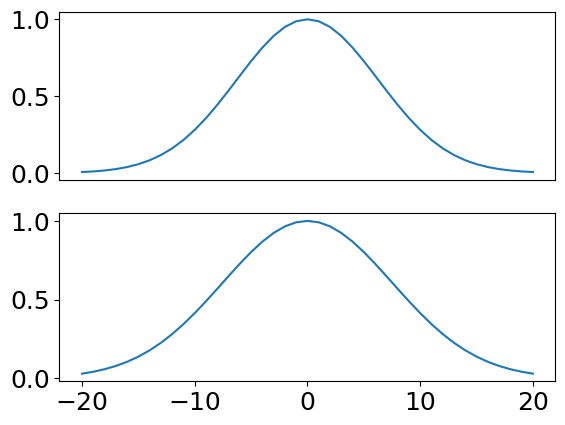

loss 67.82909393310547
r2 0.736993830547793


100%|██████████| 3000/3000 [00:47<00:00, 63.77it/s]


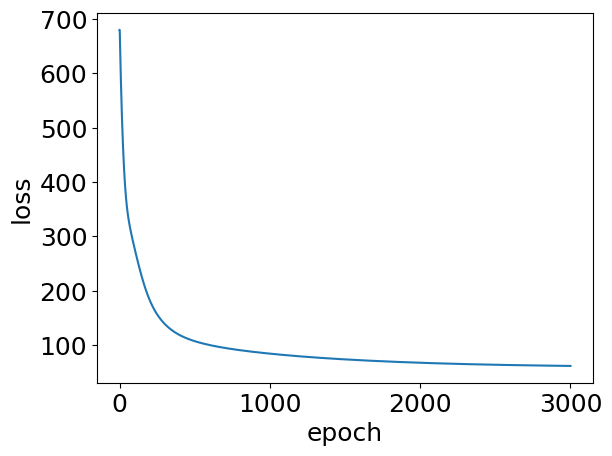

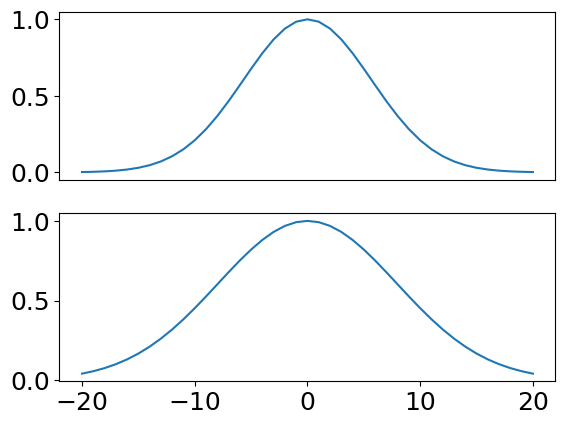

loss 61.428627014160156
r2 0.7636954812024923


100%|██████████| 3000/3000 [00:40<00:00, 74.72it/s]


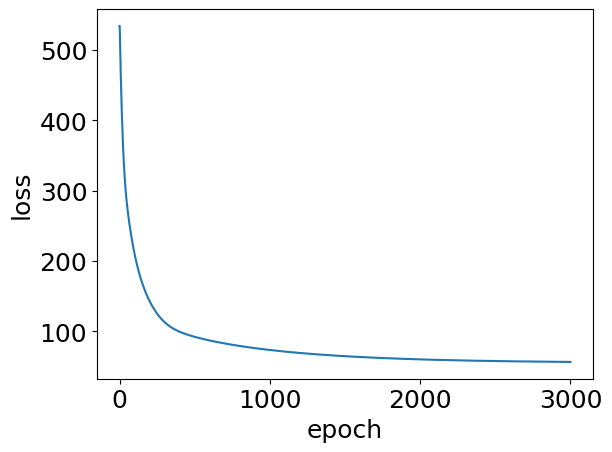

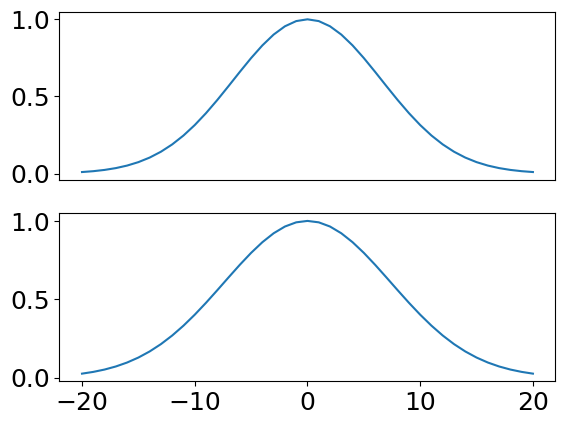

loss 56.56144714355469
r2 0.7833923424502585


100%|██████████| 3000/3000 [00:40<00:00, 74.13it/s]


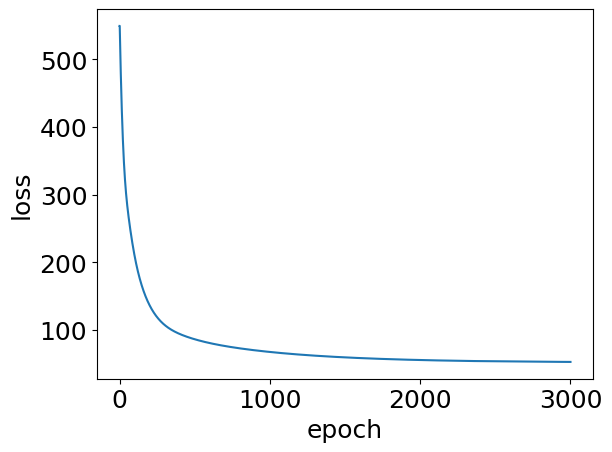

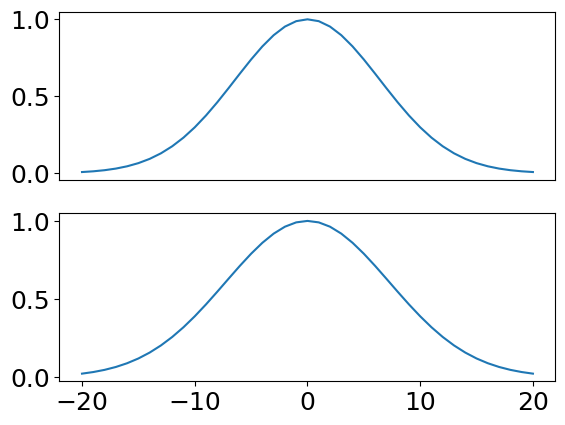

loss 52.583534240722656
r2 0.8004964028459836


100%|██████████| 3000/3000 [00:40<00:00, 74.43it/s]


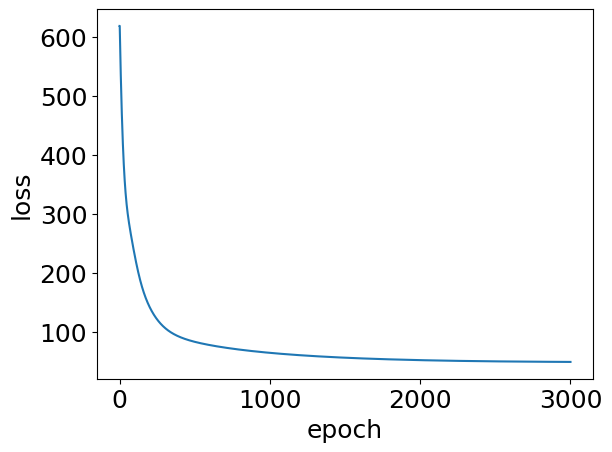

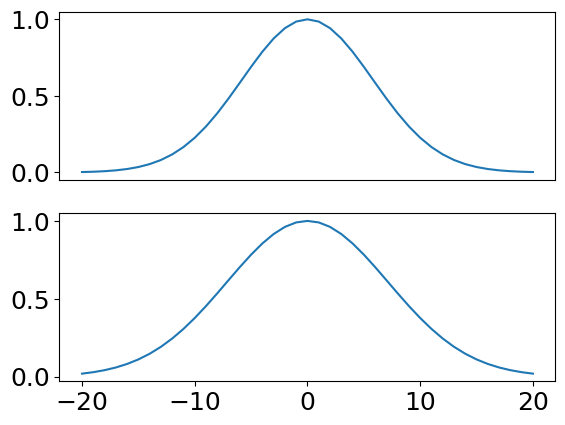

loss 49.21242904663086
r2 0.815419550163291


100%|██████████| 3000/3000 [00:43<00:00, 69.73it/s]


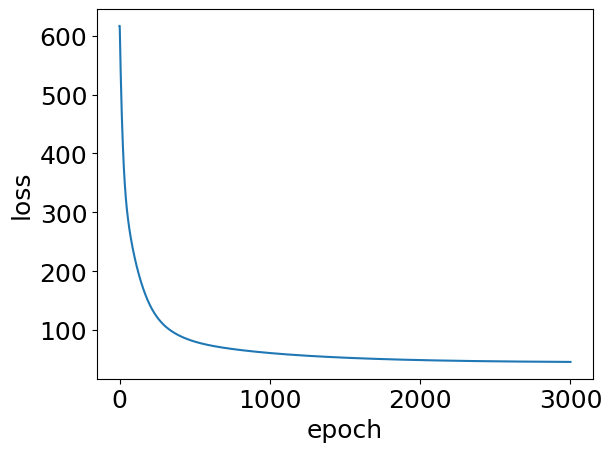

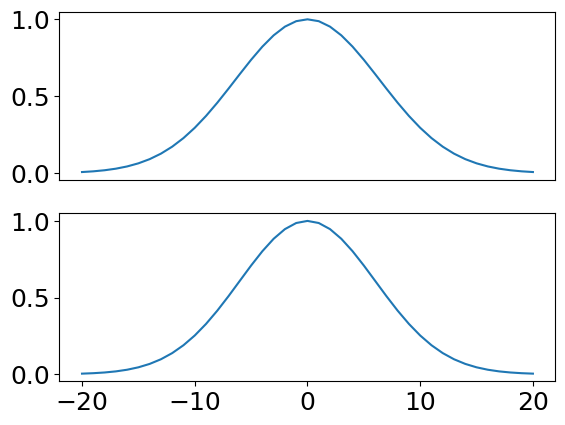

loss 45.84886932373047
r2 0.8290814891297678


100%|██████████| 3000/3000 [00:42<00:00, 70.05it/s]


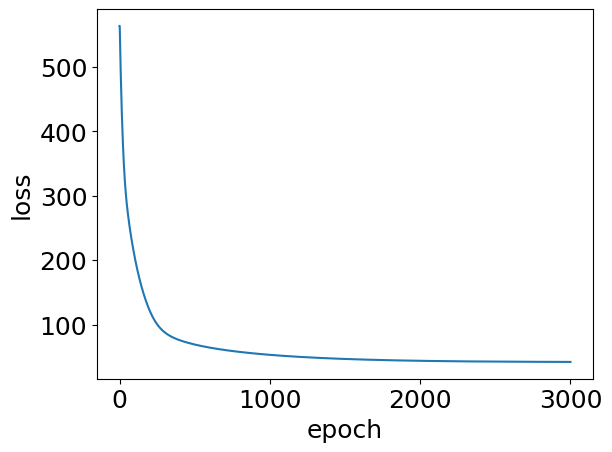

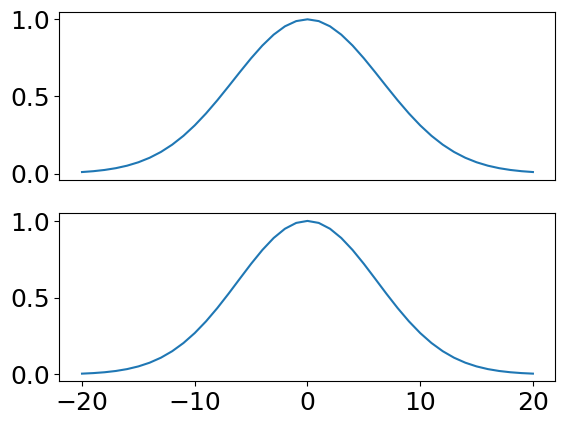

loss 41.915992736816406
r2 0.8452212298827482


100%|██████████| 3000/3000 [00:42<00:00, 70.96it/s]


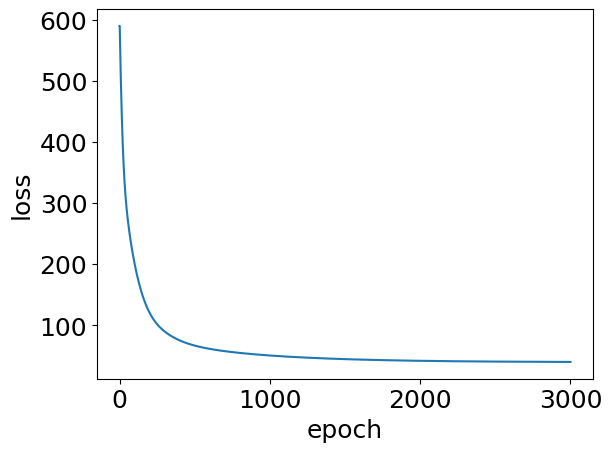

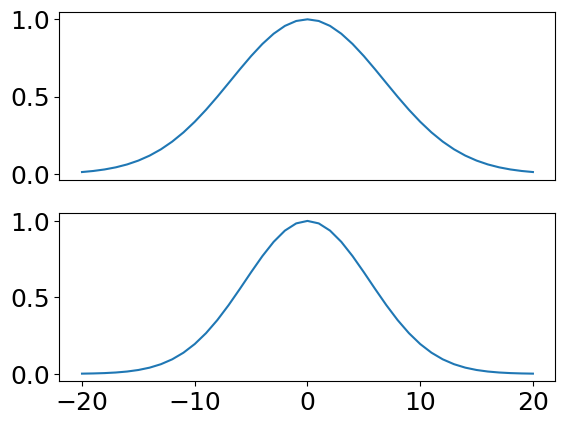

loss 39.730838775634766
r2 0.8539967880246144


100%|██████████| 3000/3000 [00:44<00:00, 67.86it/s]


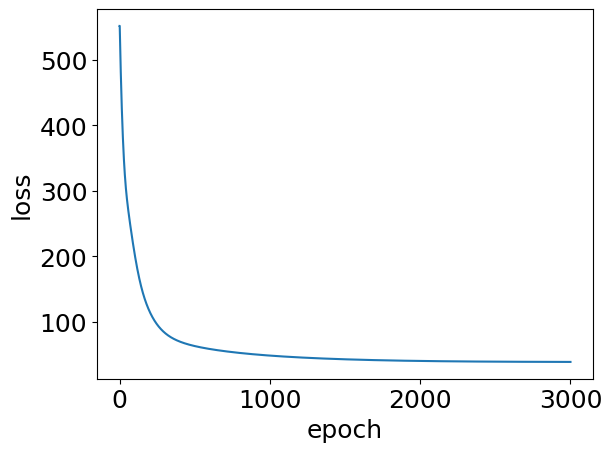

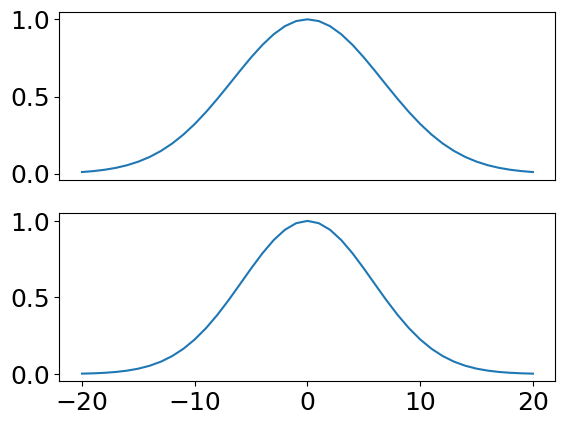

loss 38.67557907104492
r2 0.8583713865072349


100%|██████████| 3000/3000 [00:46<00:00, 64.32it/s]


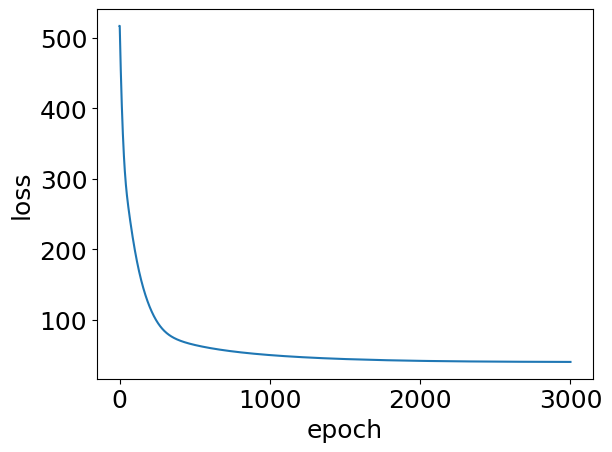

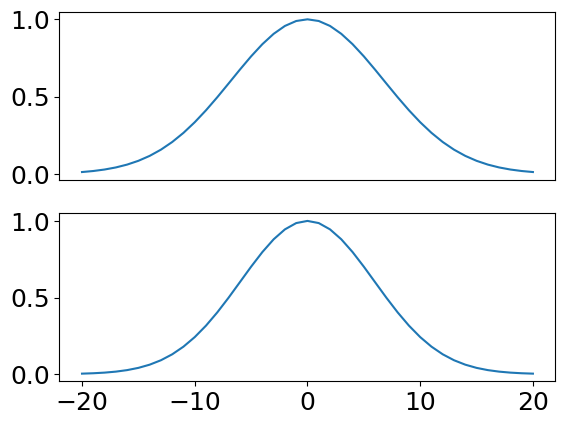

loss 40.462135314941406
r2 0.8515853365387325


100%|██████████| 3000/3000 [00:45<00:00, 66.04it/s]


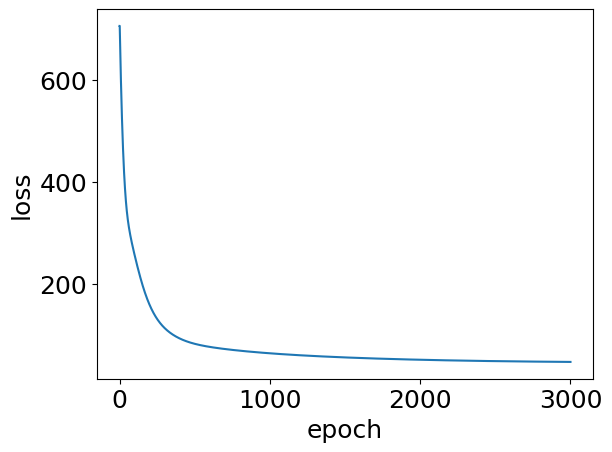

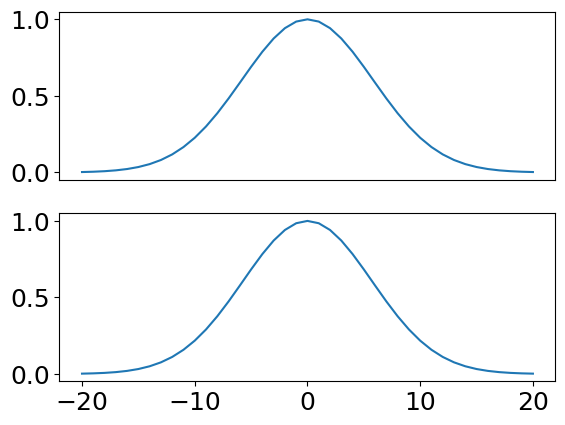

loss 46.35059356689453
r2 0.8295662316643002


100%|██████████| 3000/3000 [00:46<00:00, 64.66it/s]


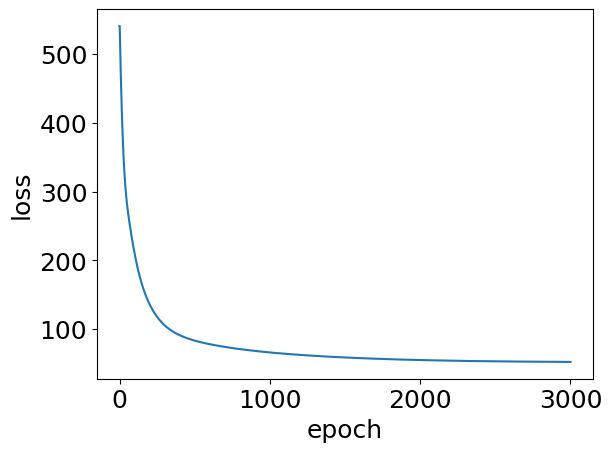

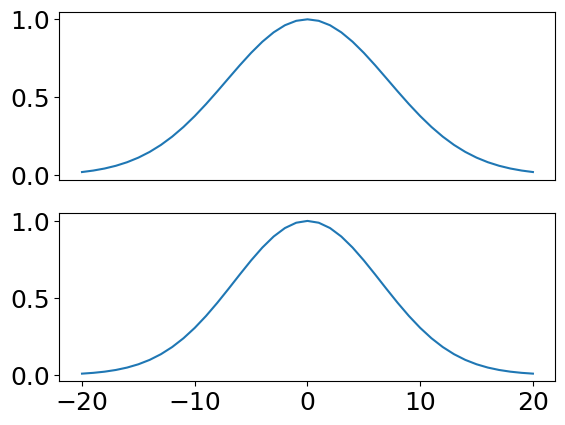

loss 52.239219665527344
r2 0.806649770566576


100%|██████████| 3000/3000 [00:44<00:00, 67.70it/s]


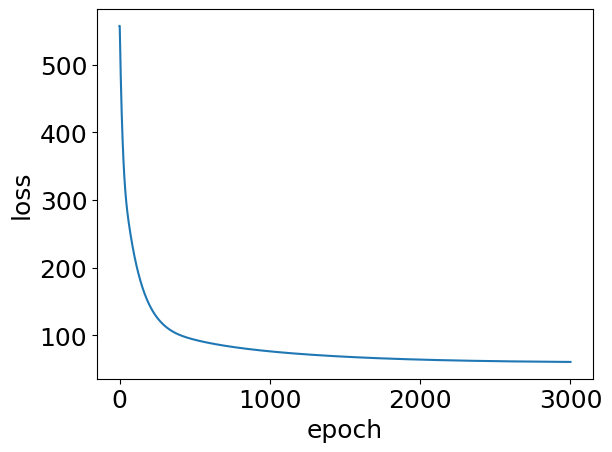

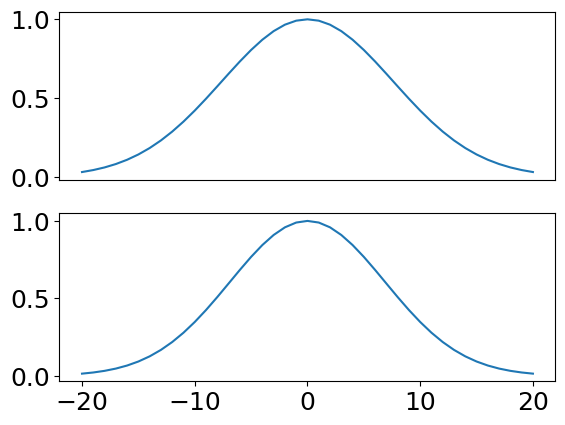

loss 60.71955490112305
r2 0.7746605590279969


100%|██████████| 3000/3000 [00:43<00:00, 69.12it/s]


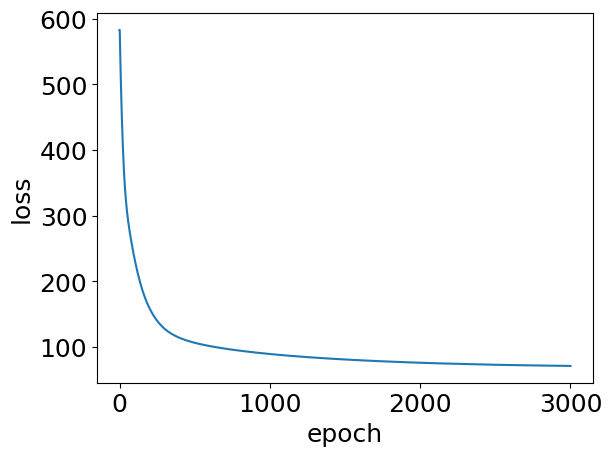

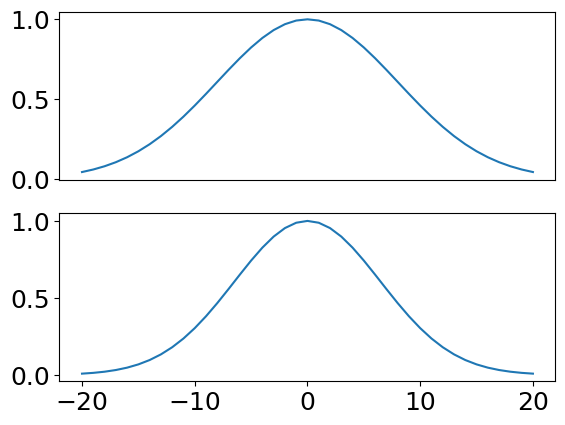

loss 70.97135162353516
r2 0.7361997764378798


100%|██████████| 3000/3000 [00:44<00:00, 67.42it/s]


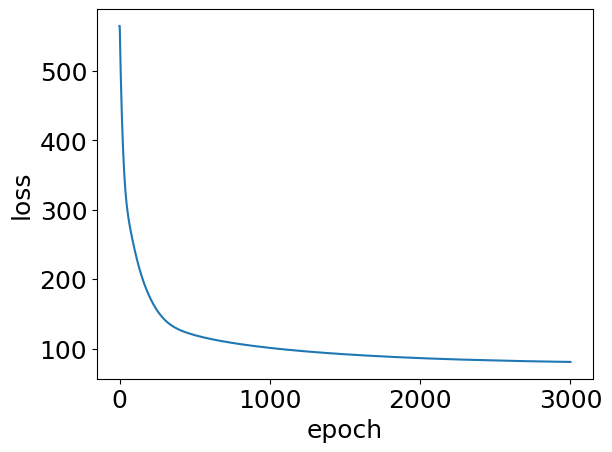

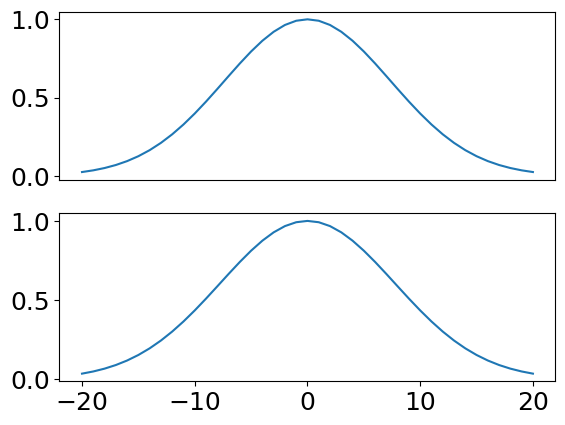

loss 80.78502655029297
r2 0.7012221700142327


100%|██████████| 3000/3000 [00:42<00:00, 70.52it/s]


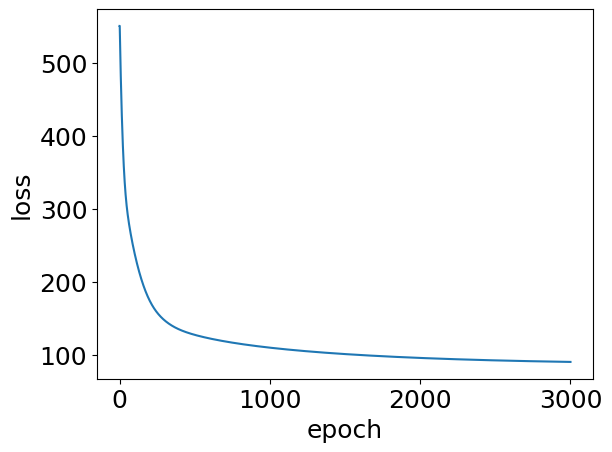

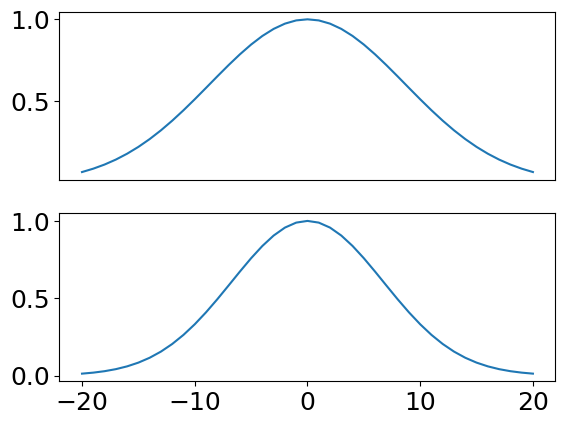

loss 90.62796783447266
r2 0.6641556394530311


100%|██████████| 3000/3000 [00:42<00:00, 70.46it/s]


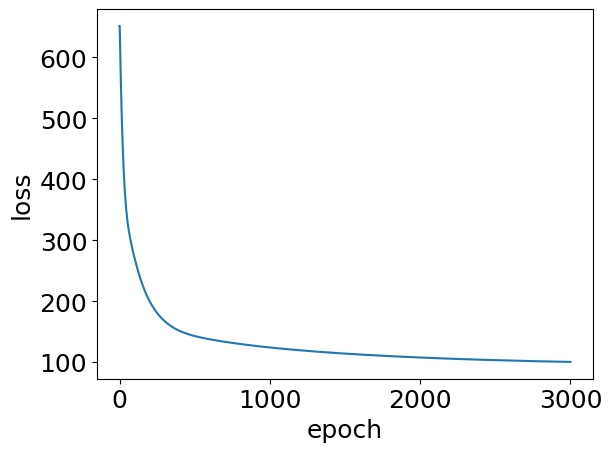

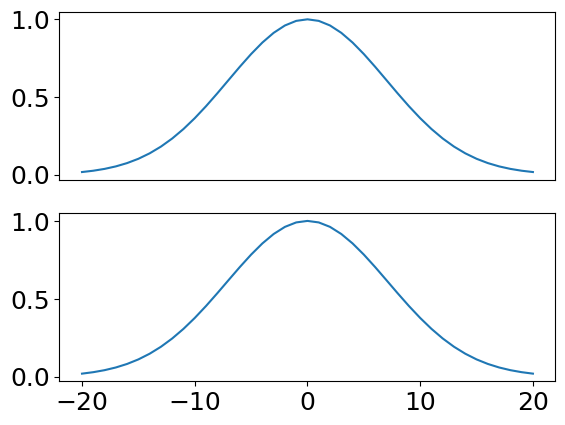

loss 100.31849670410156
r2 0.6304504482879189


100%|██████████| 3000/3000 [00:42<00:00, 69.93it/s]


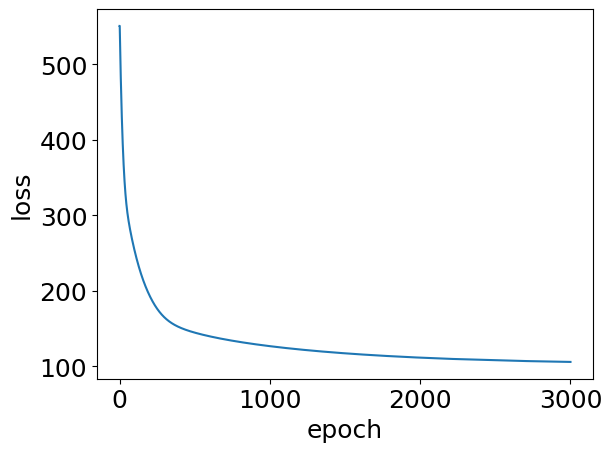

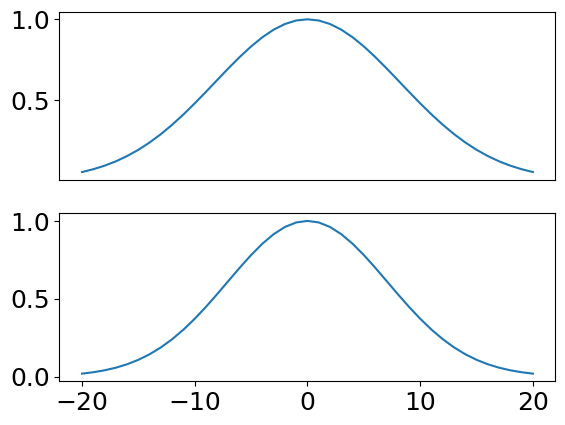

loss 105.80947875976562
r2 0.6104256614056445


100%|██████████| 3000/3000 [00:44<00:00, 67.15it/s]


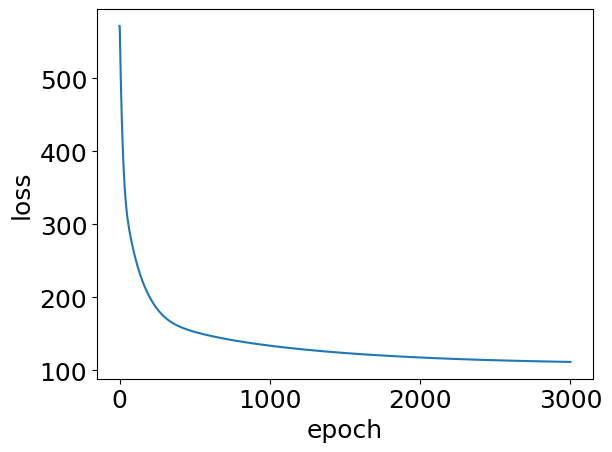

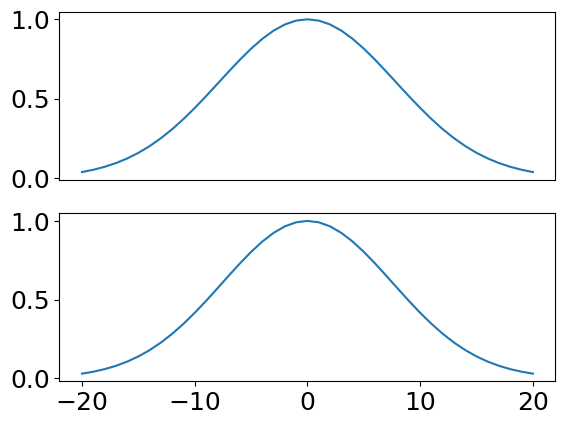

loss 111.412841796875
r2 0.5912862437128448


100%|██████████| 3000/3000 [00:43<00:00, 69.63it/s]


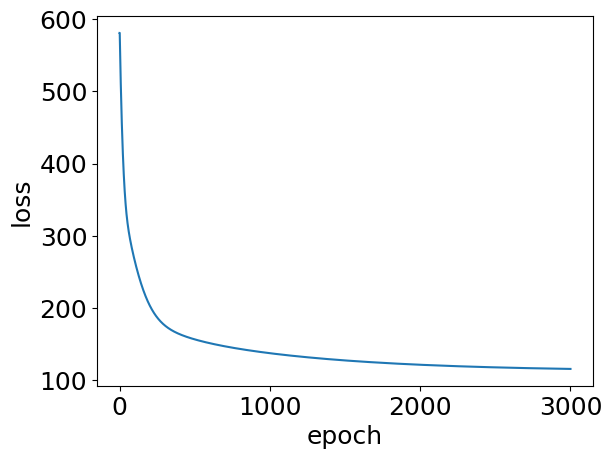

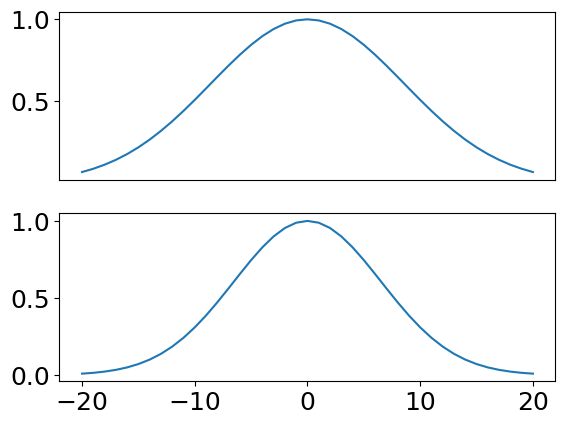

loss 115.79876708984375
r2 0.5752051019706483


100%|██████████| 3000/3000 [00:45<00:00, 66.63it/s]


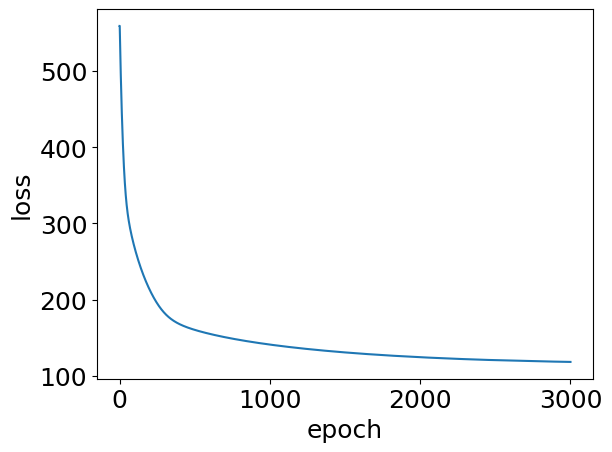

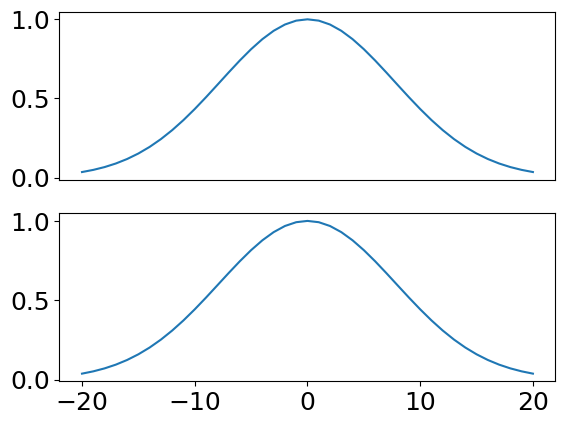

loss 118.08538055419922
r2 0.5690462165918593


100%|██████████| 3000/3000 [00:44<00:00, 66.85it/s]


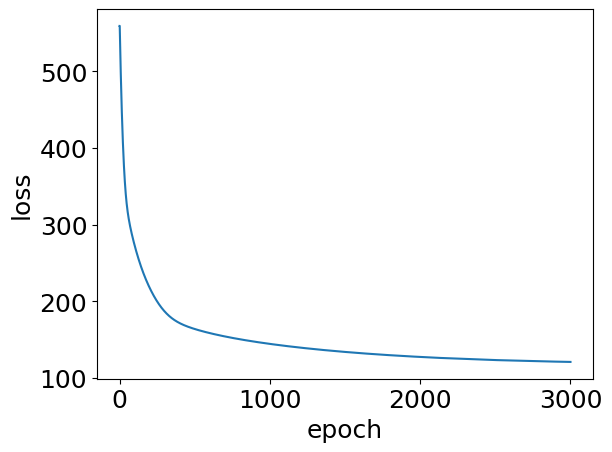

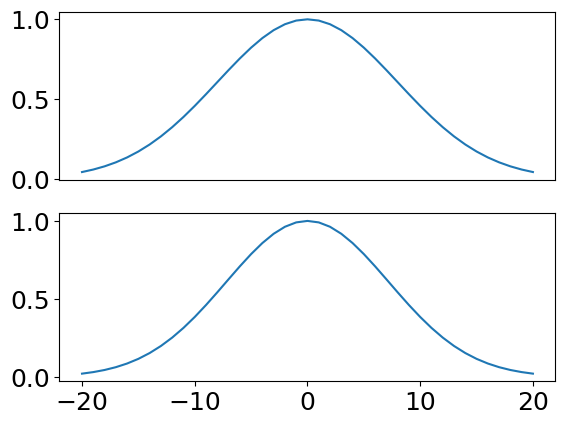

loss 120.67517852783203
r2 0.5601360149354899


100%|██████████| 3000/3000 [00:43<00:00, 68.76it/s]


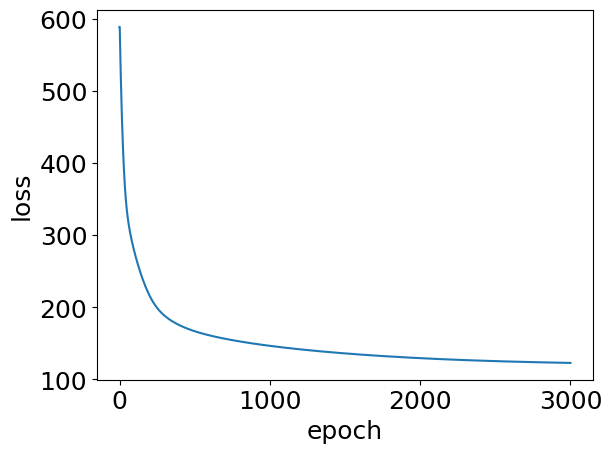

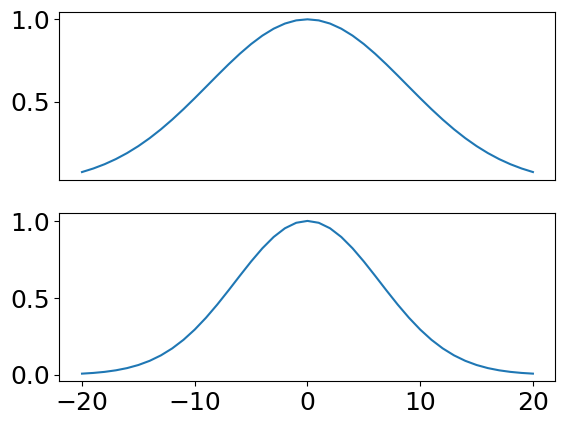

loss 122.81658935546875
r2 0.5520025189621245


100%|██████████| 3000/3000 [00:36<00:00, 82.74it/s]


0.8323026897530839


100%|██████████| 3000/3000 [00:43<00:00, 69.39it/s]


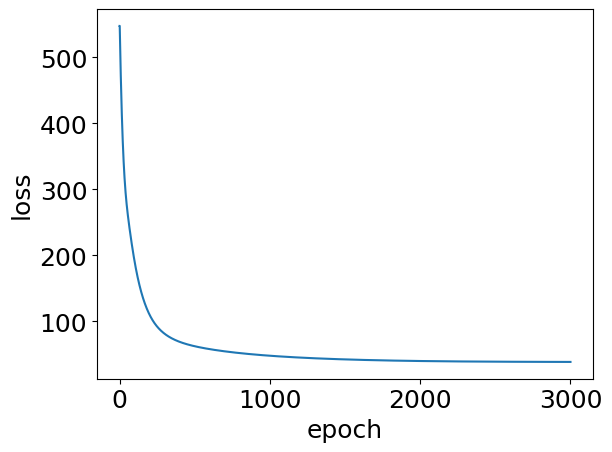

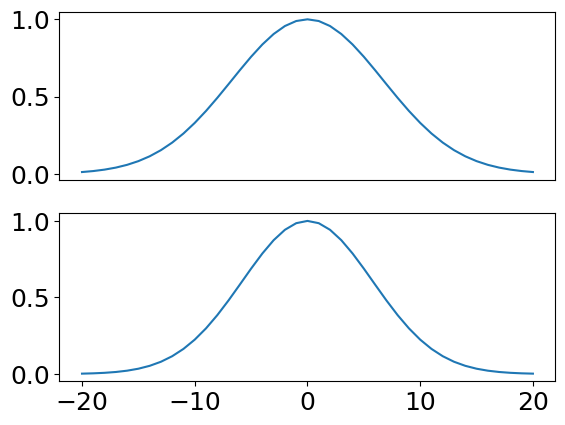

loss 38.657073974609375
r2 0.8584246888479086


100%|██████████| 3000/3000 [00:32<00:00, 91.05it/s]


In [255]:
import scipy.stats
filter = True
init = None
pred_range = (-100, 1000)
r2_array = nans([len(lag_axis)]); r2_wo_filter_array = nans([len(lag_axis)]); 
x_r2_array = nans([len(lag_axis)]); y_r2_array = nans([len(lag_axis)])
r_array = nans([len(lag_axis)])
coef_array = nans([len(lag_axis),2,dim])
if not filter:
    for i in range(len(lag_axis)):
        lag = lag_axis[i]
        r2, ldgf, vel_df, x_r2, y_r2 = fit_and_predict_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, lag, x_field, y_field,cond_dict,filter=filter,init=init)
        coef,bias = ldgf.params['weight'],ldgf.params['bias']
        r2_array[i] = r2; x_r2_array[i] = x_r2; y_r2_array[i] = y_r2
        r = scipy.stats.pearsonr(vel_df[y_field].to_numpy().reshape(-1), vel_df['pred_vel'].to_numpy().reshape(-1))[0]
        r_array[i] = r
        coef_array[i,:,:] = coef
    time_max = lag_axis[np.argmax(r2_array)]
    print(np.max(r2_array))
    _, ldgf_best, vel_df, x_r2, y_r2 = fit_and_predict_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, time_max, x_field, y_field, cond_dict=cond_dict,filter=filter,init=init)
    best_coef,best_intercept = ldgf_best.params['weight'], ldgf_best.params['bias']
else:
    for i in range(len(lag_axis)):
        lag = lag_axis[i]
        r2, r2_wo, ldgf, vel_df, x_r2, y_r2 = fit_and_predict_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, lag, x_field, y_field,cond_dict,filter=filter,init=init)
        coef,bias = ldgf.params['weight'],ldgf.params['bias']
        r2_array[i] = r2; r2_wo_filter_array[i] = r2_wo
        x_r2_array[i] = x_r2; y_r2_array[i] = y_r2
        r = scipy.stats.pearsonr(vel_df[y_field].to_numpy().reshape(-1), vel_df['pred_vel'].to_numpy().reshape(-1))[0]
        r_array[i] = r
        coef_array[i,:,:] = coef
    time_max = lag_axis[np.argmax(r2_array)]
    print(np.max(r2_array))
    _, _, ldgf_best, vel_df, x_r2, y_r2 = fit_and_predict_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, time_max, x_field, y_field, cond_dict=cond_dict,filter=filter,init=init)
    best_coef,best_intercept = ldgf_best.params['weight'], ldgf_best.params['bias']

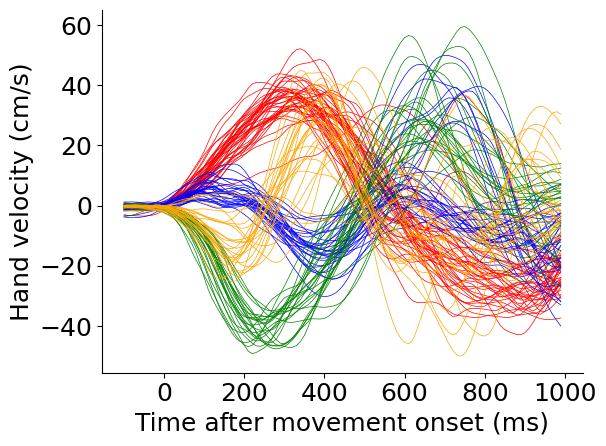

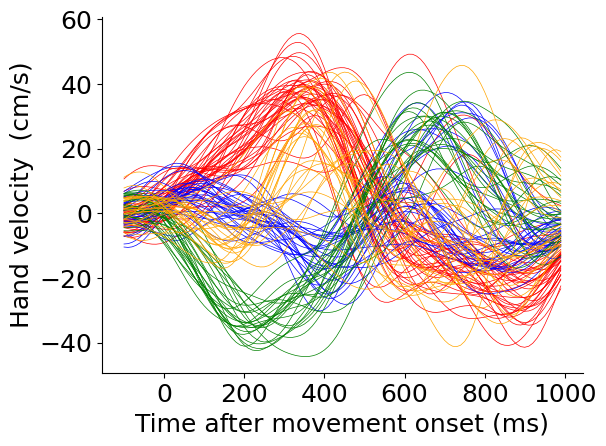

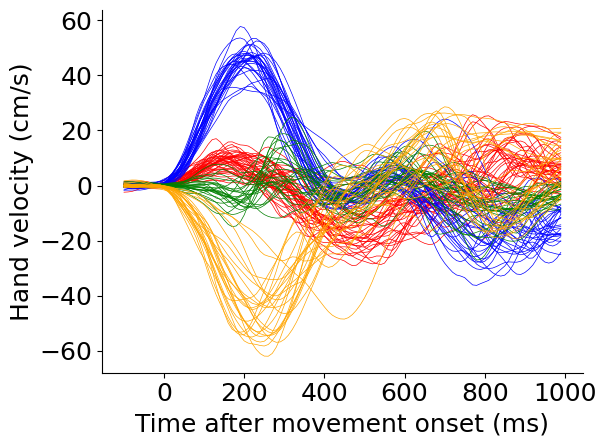

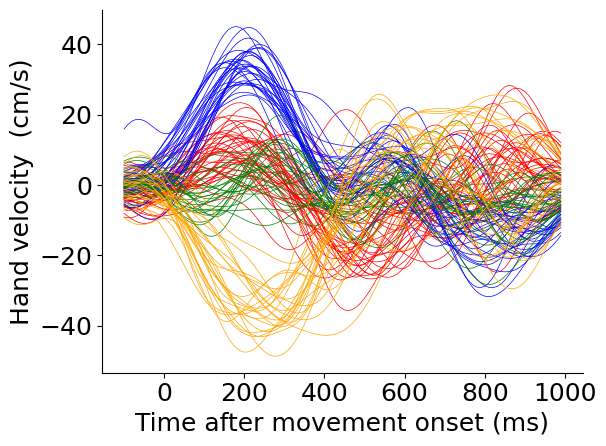

[0.35376507 0.41472203 0.4744449  0.53430557 0.58612665 0.63478134
 0.67564236 0.70659871 0.73495356 0.75579024 0.77460639 0.78822357
 0.80589664 0.82017071 0.82910283 0.83230269 0.82364903 0.80150643
 0.76745601 0.72642946 0.68006941 0.63770191 0.58830925 0.54928673
 0.51828777 0.49298611 0.47610824 0.46742338 0.45666518 0.45052303]
0


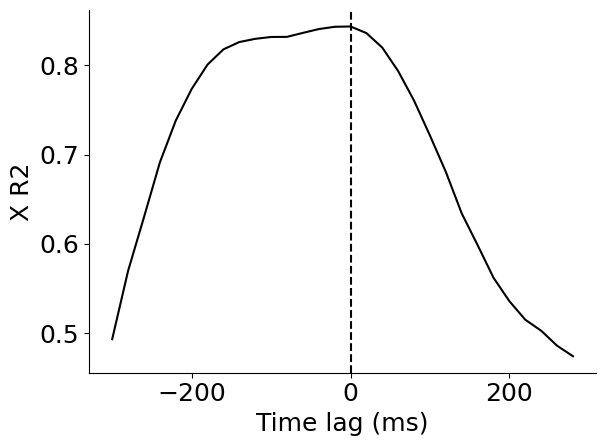

[0.35376507 0.41472203 0.4744449  0.53430557 0.58612665 0.63478134
 0.67564236 0.70659871 0.73495356 0.75579024 0.77460639 0.78822357
 0.80589664 0.82017071 0.82910283 0.83230269 0.82364903 0.80150643
 0.76745601 0.72642946 0.68006941 0.63770191 0.58830925 0.54928673
 0.51828777 0.49298611 0.47610824 0.46742338 0.45666518 0.45052303]
0


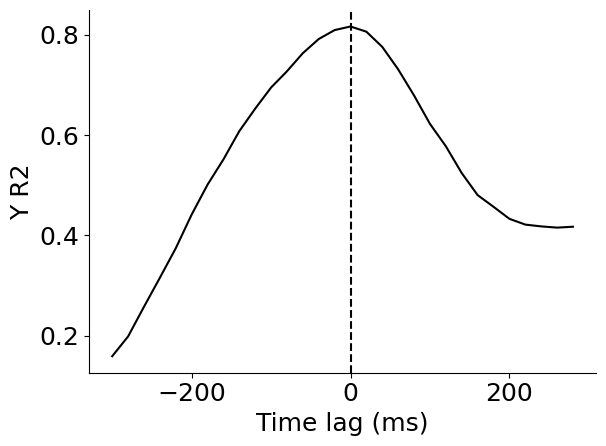

[0.35376507 0.41472203 0.4744449  0.53430557 0.58612665 0.63478134
 0.67564236 0.70659871 0.73495356 0.75579024 0.77460639 0.78822357
 0.80589664 0.82017071 0.82910283 0.83230269 0.82364903 0.80150643
 0.76745601 0.72642946 0.68006941 0.63770191 0.58830925 0.54928673
 0.51828777 0.49298611 0.47610824 0.46742338 0.45666518 0.45052303]
0


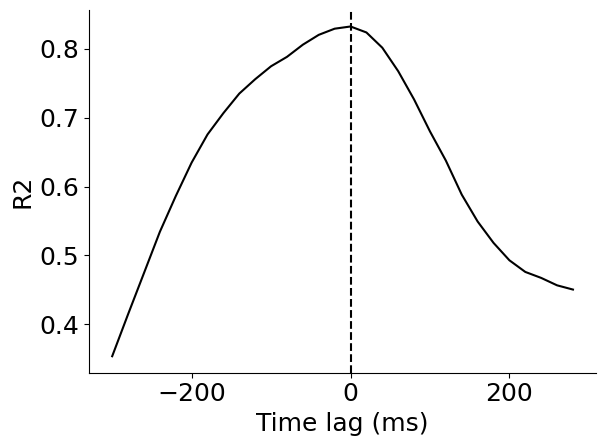

[0.03651985 0.04250964 0.05064288 0.05670829 0.06448757 0.07346976
 0.07965689 0.0860076  0.09127275 0.09614525 0.09916646 0.10665197
 0.10674887 0.11185029 0.11807519 0.11794131 0.11520251 0.10994639
 0.09988701 0.09255241 0.08401238 0.07263042 0.06908296 0.0637016
 0.0582501  0.05506572 0.05128829 0.0509517  0.05069281 0.04922143]
0


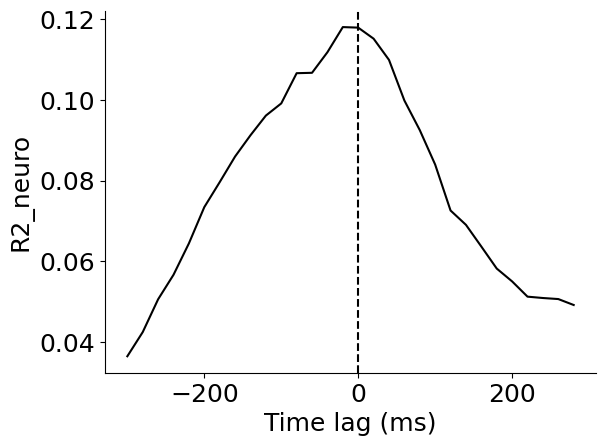

0


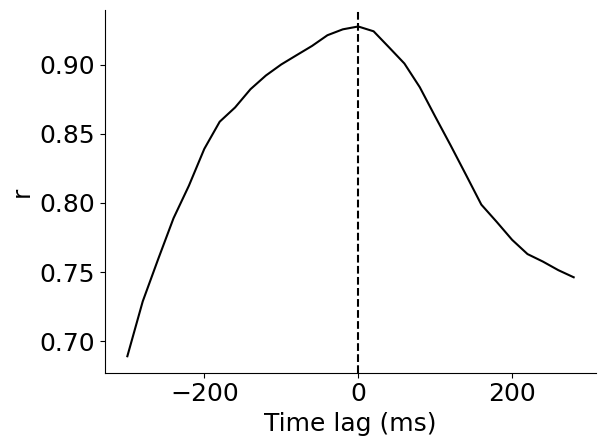

0
-20
0.0


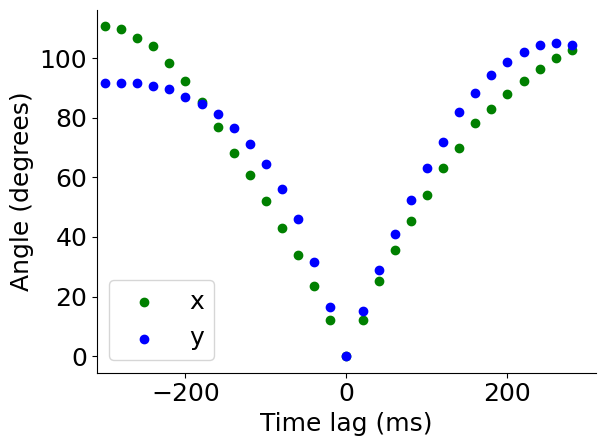

In [256]:
# Prepare for plotting
plot_dir = [0.0, 90.0, 180.0, 270.0] # limit plot directions to reduce cluttering
colors = ['red', 'blue', 'green', 'orange']
plot_dim = 'x' # plot x velocity 

x_axis = np.arange(-100,1000,dataset.bin_width)
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
        plt.plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
        # plt.plot(x_axis, trial[y_field].to_numpy()[:,0], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
# plt.ylabel('Shoulder angle')
# plt.ylabel('Shoulder velocity')
# plt.ylabel('Muscle pc (au)')
# plt.ylabel('Hand position (cm)')
# plt.ylabel('Hand velocity (cm/s)')
plt.ylabel('Hand velocity (cm/s)')

# plt.xlim([-100,500])
# plt.ylim([-0.65,0.65])
plt.tight_layout()
# plt.savefig(figDir + monkey + label + 'true.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
         plt.plot(x_axis, trial['pred_vel'][plot_dim], color=color, linewidth=0.5)
        # plt.plot(x_axis, trial.pred_vel.to_numpy()[:,0], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
# plt.ylabel('Shoulder angle')
# plt.ylabel('Shoulder velocity')
# plt.ylabel('Muscle pc (au)')
# plt.ylabel('Hand position (cm)')
# plt.ylabel('Hand velocity (cm/s)')
plt.ylabel('Hand velocity  (cm/s)')
# plt.xlim([-100,500])
# plt.ylim([-0.65,0.65])
plt.tight_layout()
# plt.savefig(figDir + monkey + label + str(0) +'_pred.pdf', dpi = 'figure')
plt.show()

plot_dim = 'y' # plot x velocity 

x_axis = np.arange(-100,1000,dataset.bin_width)
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
        plt.plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
        # plt.plot(x_axis, trial[y_field].to_numpy()[:,0], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
# plt.ylabel('Shoulder angle')
# plt.ylabel('Shoulder velocity')
# plt.ylabel('Muscle pc (au)')
# plt.ylabel('Hand position (cm)')
# plt.ylabel('Hand velocity (cm/s)')
plt.ylabel('Hand velocity (cm/s)')

# plt.xlim([-100,500])
# plt.ylim([-0.65,0.65])
plt.tight_layout()
# plt.savefig(figDir + monkey + label + 'true.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
         plt.plot(x_axis, trial['pred_vel'][plot_dim], color=color, linewidth=0.5)
        # plt.plot(x_axis, trial.pred_vel.to_numpy()[:,0], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
# plt.ylabel('Shoulder angle')
# plt.ylabel('Shoulder velocity')
# plt.ylabel('Muscle pc (au)')
# plt.ylabel('Hand position (cm)')
# plt.ylabel('Hand velocity (cm/s)')
plt.ylabel('Hand velocity  (cm/s)')
# plt.xlim([-100,500])
# plt.ylim([-0.65,0.65])
plt.tight_layout()
# plt.savefig(figDir + monkey + label + str(0) +'_pred.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis, x_r2_array,color = 'k')
plt.axvline(time_max, color = 'k', linestyle='--')
print(r2_array)
print(time_max)
# plt.title('R2 score predicting ' + y_field + ' ' + str(pred_range))
plt.xlabel('Time lag (ms)')
plt.ylabel('X R2')
# plt.ylim([0.00,0.5])
plt.tight_layout()
# plt.savefig(figDir + monkey +'_acc_' + str(0) +'.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis, y_r2_array,color = 'k')
plt.axvline(time_max, color = 'k', linestyle='--')
print(r2_array)
print(time_max)
# plt.title('R2 score predicting ' + y_field + ' ' + str(pred_range))
plt.xlabel('Time lag (ms)')
plt.ylabel('Y R2')
# plt.ylim([0.00,0.5])
plt.tight_layout()
# plt.savefig(figDir + monkey +'_acc_' + str(0) +'.pdf', dpi = 'figure')
plt.show()


fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis, r2_array,color = 'k')
plt.axvline(time_max, color = 'k', linestyle='--')
print(r2_array)
print(time_max)
# plt.title('R2 score predicting ' + y_field + ' ' + str(pred_range))
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
# plt.ylim([0.00,0.5])
plt.tight_layout()
# plt.savefig(figDir + monkey +'_acc_' + str(0) +'.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis, r2_wo_filter_array,color = 'k')
plt.axvline(time_max, color = 'k', linestyle='--')
print(r2_wo_filter_array)
print(time_max)
# plt.title('R2 score predicting ' + y_field + ' ' + str(pred_range))
plt.xlabel('Time lag (ms)')
plt.ylabel('R2_neuro')
# plt.ylim([0.00,0.5])
plt.tight_layout()
# plt.savefig(figDir + monkey +'_acc_' + str(0) +'.pdf', dpi = 'figure')
plt.show()


fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis, r_array,color = 'k')
plt.axvline(time_max, color = 'k', linestyle='--')
print(time_max)
plt.xlabel('Time lag (ms)')
plt.ylabel('r')
# plt.ylim([0.05,0.8])
plt.tight_layout()
# plt.savefig(figDir + monkey +'_vel_' + str(0) +'.pdf', dpi = 'figure')
plt.show()

idx_max_pos = np.argwhere(r2_array == np.max(r2_array[np.argwhere(lag_axis==0)[0,0]:]))[0,0]
idx_max_neg = np.argwhere(r2_array == np.max(r2_array[:np.argwhere(lag_axis==0)[0,0]]))[0,0]
print(lag_axis[idx_max_pos])
print(lag_axis[idx_max_neg])

#For velocity, override max identification
# idx_max_pos = np.argwhere(lag_axis==80)[0,0]
# idx_max_neg = np.argwhere(lag_axis==-40)[0,0]

ang_to_max_x = nans([len(lag_axis)])
ang_to_max_y = nans([len(lag_axis)])
# ang_to_max_z = nans([len(lag_axis)])
for i in range(0, len(coef_array)):
    ang_to_max_x[i] = math.degrees(angle_between(coef_array[i,0,:],coef_array[idx_max_pos,0,:]))
    ang_to_max_y[i] = math.degrees(angle_between(coef_array[i,1,:],coef_array[idx_max_pos,1,:]))
    # ang_to_max_z[i] = math.degrees(angle_between(coef_array[i,2,:],coef_array[idx_max_neg,2,:]))
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.ylim([-5, 130])
plt.xlim([-310, 310])
plt.scatter(lag_axis, ang_to_max_x,label = 'x',color = 'green')
plt.scatter(lag_axis, ang_to_max_y,label = 'y',color = 'blue')
# plt.scatter(lag_axis, ang_to_max_z,label = 'wrist_abduction',color = 'orange')

plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('Angle (degrees)')
mean = np.mean([ang_to_max_x[idx_max_pos], ang_to_max_y[idx_max_pos]])
print(mean)
# plt.vlines(lag_axis[idx_max_pos],-5, mean, color = 'k',linestyle="dashed")
# plt.hlines(mean, -310, lag_axis[idx_max_pos], color = 'k',linestyle="dashed")
plt.tight_layout()
# plt.savefig(figDir + monkey + label + str(0) +'_angle.pdf', dpi = 'figure')
plt.show()

